In [1]:
import os
from glob import glob

import numpy as np
import pandas as pd
import xarray as xr
#import dask.dataframe as dd
from xhistogram.xarray import histogram
from xmitgcm import llcreader
import geopandas as gpd

%matplotlib inline
from matplotlib import pyplot as plt
from cartopy import crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
import mitequinox.parcels as pa

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5685666.datarmor0/parcels-502090/libparcels_random_7956d407-d1ca-47dd-9ced-4221ccf6fe56.so


In [2]:
from dask.distributed import Client, LocalCluster
#
#cluster = LocalCluster()
#
from dask_jobqueue import PBSCluster
cluster = PBSCluster() #processes=7, cores=7
w = cluster.scale(jobs=3)

client = Client(cluster)

In [3]:
client

Client Scheduler: tcp://10.148.0.255:34200 Dashboard: http://10.148.0.255:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Lagrangian spectra

In [4]:
# Lagrangian data
root_dir = '/home/datawork-lops-osi/equinox/mit4320/parcels/'
run_name = 'global_extra_T365j_dt1j_dij50'

p = pa.parcels_output(root_dir+run_name, parquets=['time_mean'])

In [7]:
df_Lspectra_mean0 = p.load_diagnostic('spectra_T60_uv_mean0').persist()#persist()
#df_Lspectra_mean1 = p.load_diagnostic('spectra_raw_uv_mean1').persist()#persist()
#df_Lspectra_mean2 = p.load_diagnostic('spectra_raw_uv_mean2').persist()#compute()

AttributeError: 'str' object has no attribute 'parquet_path'

In [7]:
bathy = ut.load_bathy(15)

In [8]:
import dask.dataframe as dd
_df = df_Lspectra_mean0[['lon','lat']].persist()
ds = xr.Dataset.from_dataframe(_df)
ds_interpolated = bathy.interp(lon=ds['lon'], lat=ds['lat'])
df_interpolated = ds_interpolated.to_dataframe()[bathy.name].to_frame()
ddf = dd.from_pandas(df_interpolated,npartitions=81)
df_Lspectra_mean0 = df_Lspectra_mean0.merge(ddf).persist()

In [9]:
_df = df_Lspectra_mean1[['lon','lat']].persist()
ds = xr.Dataset.from_dataframe(_df)
ds_interpolated = bathy.interp(lon=ds['lon'], lat=ds['lat'])
df_interpolated = ds_interpolated.to_dataframe()[bathy.name].to_frame()
ddf = dd.from_pandas(df_interpolated,npartitions=81)
df_Lspectra_mean1 = df_Lspectra_mean1.merge(ddf).persist()

In [10]:
_df = df_Lspectra_mean2[['lon','lat']].persist()
ds = xr.Dataset.from_dataframe(_df)
ds_interpolated = bathy.interp(lon=ds['lon'], lat=ds['lat'])
df_interpolated = ds_interpolated.to_dataframe()[bathy.name].to_frame()
ddf = dd.from_pandas(df_interpolated,npartitions=81)
df_Lspectra_mean2 = df_Lspectra_mean2.merge(ddf).persist()

In [11]:
#for dfL in [df_Lspectra_mean0,df_Lspectra_mean1,df_Lspectra_mean2]:
df_Lspectra_mean0 = df_Lspectra_mean0[df_Lspectra_mean0['h']>500]
df_Lspectra_mean1 = df_Lspectra_mean1[df_Lspectra_mean1['h']>500]
df_Lspectra_mean2 = df_Lspectra_mean2[df_Lspectra_mean2['h']>500]

In [26]:
df_Lspectra_mean0 = df_Lspectra_mean0.persist()

### Eulerian spectra

In [12]:
sub = 2
ds_E = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T60.zarr'))
ds_E = ds_E.isel(i=slice(0,None,sub),j=slice(0,None,sub))
ds_E = ds_E.where(ds_E.Depth>500, drop=False)
print(ds_E)

<xarray.Dataset>
Dimensions:    (face: 13, freq_time: 1440, i: 540, j: 540)
Coordinates:
    Depth      (face, j, i) float32 dask.array<chunksize=(1, 540, 540), meta=np.ndarray>
    XC         (face, j, i) float32 dask.array<chunksize=(1, 540, 540), meta=np.ndarray>
    YC         (face, j, i) float32 dask.array<chunksize=(1, 540, 540), meta=np.ndarray>
  * face       (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * freq_time  (freq_time) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * i          (i) int64 0 8 16 24 32 40 48 ... 4272 4280 4288 4296 4304 4312
  * j          (j) int64 0 8 16 24 32 40 48 ... 4272 4280 4288 4296 4304 4312
    mask       (face, j, i) bool dask.array<chunksize=(1, 540, 540), meta=np.ndarray>
Data variables:
    SSUV       (face, j, i, freq_time) float64 dask.array<chunksize=(1, 24, 36, 1440), meta=np.ndarray>


In [13]:
ds_E_nomean = xr.open_zarr(os.path.join(ut.root_data_dir,'diags/SSUV_T60_nomean.zarr'))
ds_E_nomean = ds_E_nomean.isel(i=slice(0,None,sub),j=slice(0,None,sub))
ds_E_nomean = ds_E_nomean.where(ds_E_nomean.Depth>500, drop=False)

### Sites of interest

In [14]:
def binned_spectra_site(bbox,df,dl):
    df_sub = df[(df.lat<bbox[3])&(df.lat>bbox[2])&(df.lon<bbox[1])&(df.lon>bbox[0])
                                               ].persist()

    lon = np.arange(bbox[0],bbox[1], dl)
    lat = np.arange(bbox[-2], bbox[-1], dl)
    df_sub['lon'] = (df_sub['lon']+180)%360 - 180
    df_sub['lon_cut'] = df_sub['lon'].map_partitions(pd.cut, lon)
    df_sub['lat_cut'] = df_sub['lat'].map_partitions(pd.cut, lat)
    df_sub = df_sub.persist()
    if np.isin('h',df_sub.columns):
        df_sub = df_sub.drop(columns=['h'])
    uv_sub = df_sub.groupby(['lat_cut']).mean().compute()
    _ds = pd.melt(uv_sub.set_index(uv_sub.index.map(lambda v: v.mid)
                                  ).drop(columns=['time','lon','lat']
                                        ).reset_index(),id_vars=['lat_cut'],var_name='frequency')

    _ds['frequency'] = _ds['frequency'].astype('float64')
    ds_sub = _ds.rename(columns={'lat_cut': 'lat_bins', 'value': 'uv'}
                   ).to_xarray().set_index(index=['lat_bins','frequency']).unstack()
    return ds_sub

In [15]:
def binned_Espectra_site(bbox,ds,dl):
    ds['lat'] = 0*ds_E.face+ds.YC
    ds['lon'] = 0*ds_E.face+ds.XC
    ds['lat4'] = 0*ds_E.SSUV+ds.YC
    ds = ds.persist()
    ds_sub = ds.where((ds.lat<=bbox[3])&(ds.lat>=bbox[2])&(ds.lon<=bbox[1])&(ds.lon>=bbox[0]),drop=True).persist()
    lat = np.arange(bbox[-2], bbox[-1], dl)
    N = histogram(ds_sub.lat, bins=[lat], 
              dim=['i', 'j', 'face']
             ).persist()
    E = histogram(ds_sub.lat4.rename('lat'), bins=[lat], 
              weights=ds_sub.SSUV, 
              dim=['i', 'j', 'face']
             )

    E = (E/N).rename('E_SSUV').persist()
    E = E.rename({'freq_time': 'frequency','lat_bin':'lat_bins'})
    return E

#### California : 

In [16]:
bbox = [-128, -123, 33, 38] # small bbox

In [17]:
dl = 1.

In [18]:
df_mean0_Cal = binned_spectra_site(bbox,df_Lspectra_mean0,dl);
df_mean1_Cal = binned_spectra_site(bbox,df_Lspectra_mean1,dl);
df_mean2_Cal = binned_spectra_site(bbox,df_Lspectra_mean2,dl);

In [19]:
ds_Cal = xr.merge([df_mean0_Cal,df_mean1_Cal.uv.rename('uv_mean1')
                   ,df_mean2_Cal.uv.rename('uv_mean2')])

In [20]:
dsE_Cal = binned_Espectra_site(bbox,ds_E,dl)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
distributed.core - ERROR - Exception while handling op heartbeat_worker
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/core.py", line 497, in handle_comm
    result = handler(comm, **msg)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/scheduler.py", line 3820, in heartbeat_worker
    ws._executing = {
  File "/home1/datahome/zcaspar

In [21]:
dsE_Cal_nomean = binned_Espectra_site(bbox,ds_E_nomean,dl)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [22]:
dsE_Cal_nomean.name = 'E_SSUV_nomean'

dsE_Cal = xr.merge([dsE_Cal,dsE_Cal_nomean])

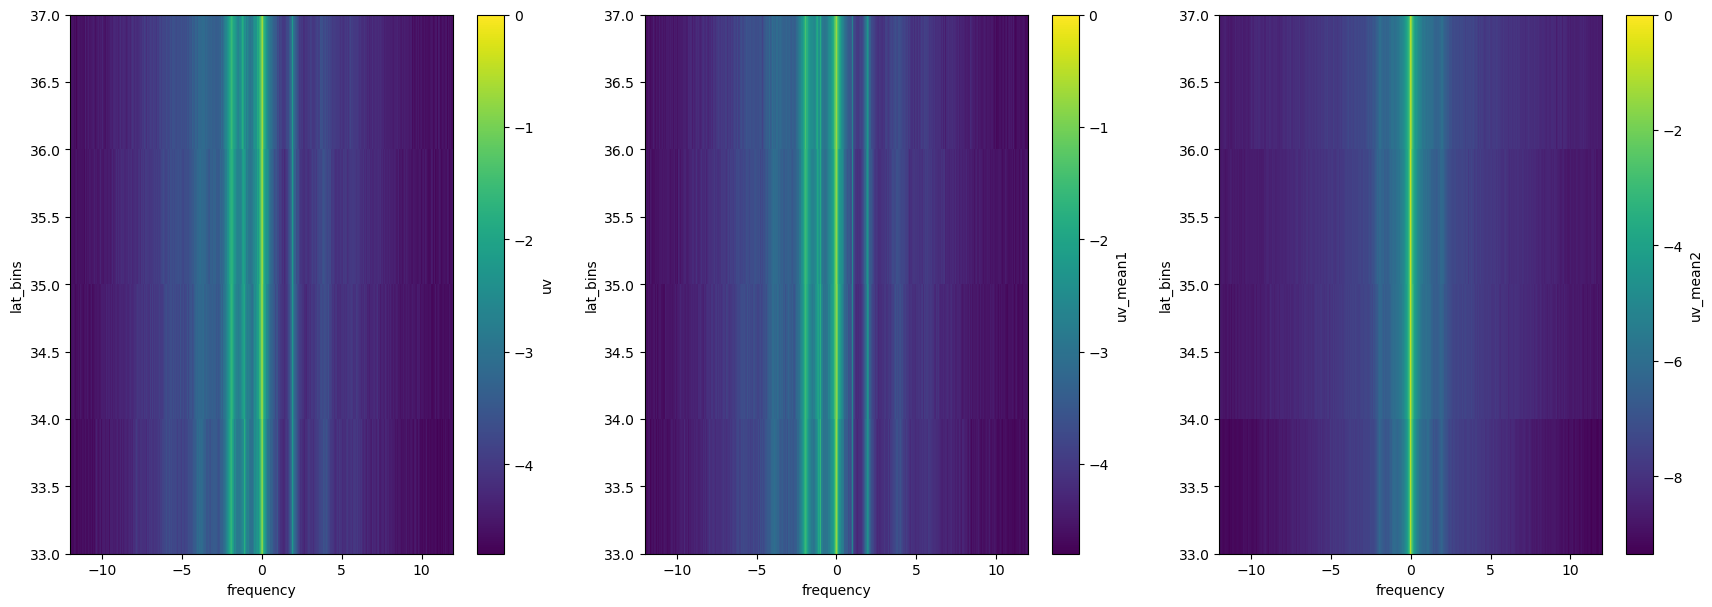

In [23]:
fig, axs = plt.subplots(1,len(ds_Cal.keys()),figsize=(len(ds_Cal.keys())*7,7))
for V,ax in zip(ds_Cal.keys(),axs):
    np.log10(ds_Cal[V]).plot(ax=ax,vmax=0)

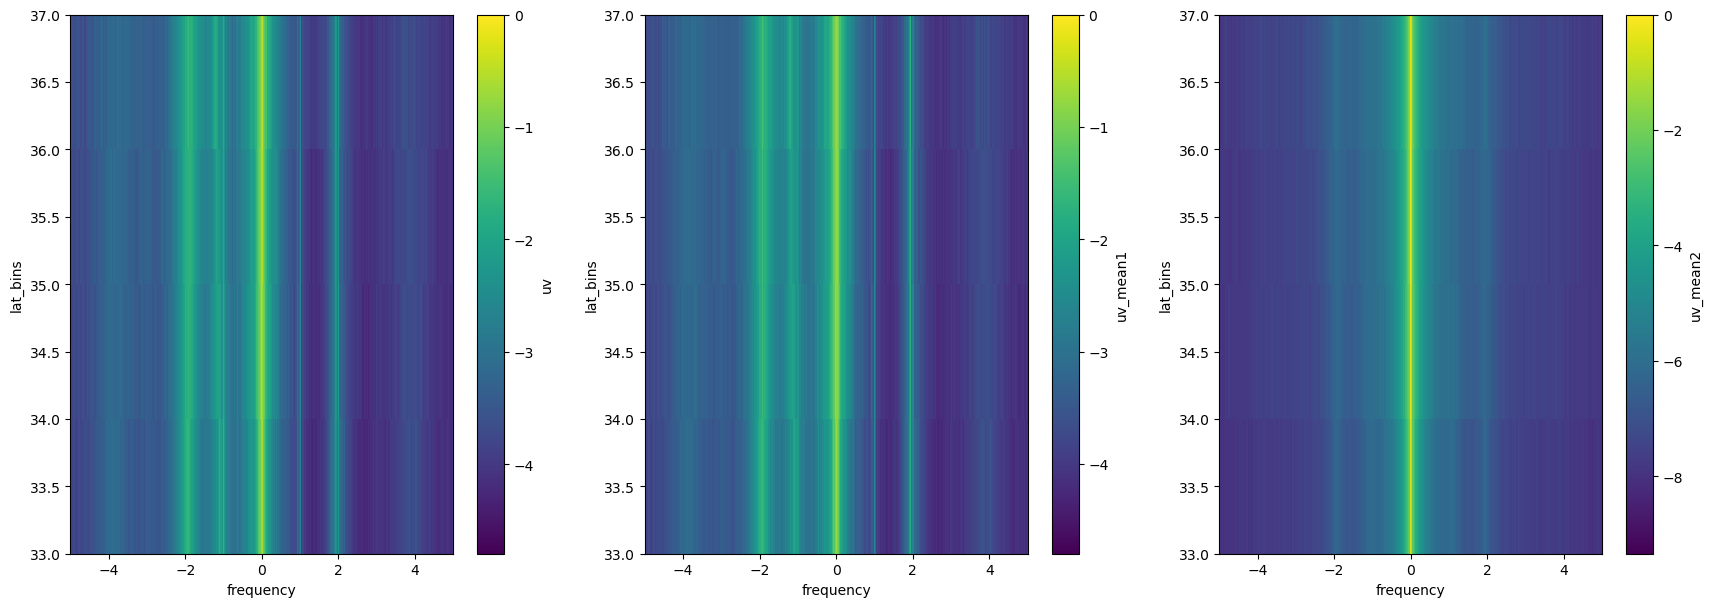

In [24]:
fig, axs = plt.subplots(1,len(ds_Cal.keys()),figsize=(len(ds_Cal.keys())*7,7))
for V,ax in zip(ds_Cal.keys(),axs):
    np.log10(ds_Cal[V]).plot(ax=ax,vmax=0)
    ax.set_xlim(-5,5)

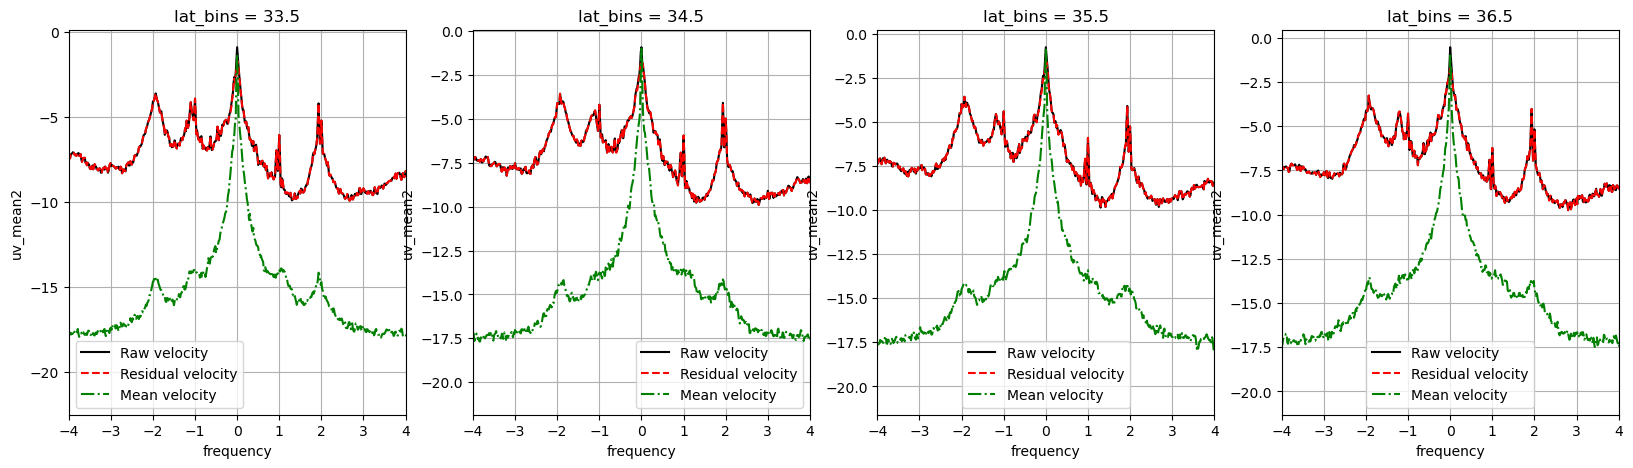

In [27]:
colors=['k','r','g']
styles=['-','--','-.']
labels=['Raw velocity','Residual velocity','Mean velocity']
fig,axs = plt.subplots(1,len(ds_Cal.lat_bins.values),figsize=(len(ds_Cal.lat_bins.values)*5,5))
for V,c,style in zip(ds_Cal.keys(),colors,styles):
    for i,ax in enumerate(axs):
    
        np.log(ds_Cal[V].isel(lat_bins=i)).plot(c=c,linestyle=style,ax=ax
                                           )
        ax.set_xlim(-4,4)
        ax.legend(labels)
        ax.grid()

(-5.0, 5.0)

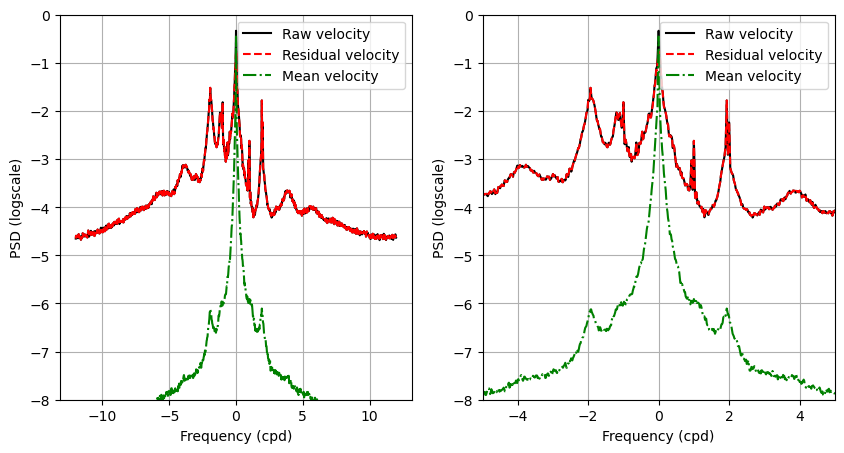

In [102]:
colors=['k','r','g']
styles=['-','--','-.']
labels=['Raw velocity','Residual velocity','Mean velocity']
fig, ax = plt.subplots(1,2,figsize=(10,5))
for V,c,style in zip(ds_Cal.keys(),colors,styles):
    np.log10(ds_Cal[V].mean(['lat_bins'])).plot(ax=ax[0],c=c,linestyle=style)
    np.log10(ds_Cal[V].mean(['lat_bins'])).plot(ax=ax[1],c=c,linestyle=style)
for a in ax:
    a.grid();a.set_ylim(-8,0);a.set_ylabel('PSD (logscale)')
    a.set_xlabel('Frequency (cpd)');
    a.legend(labels)
ax[1].set_xlim(-5,5)

#### Plot Eulérien

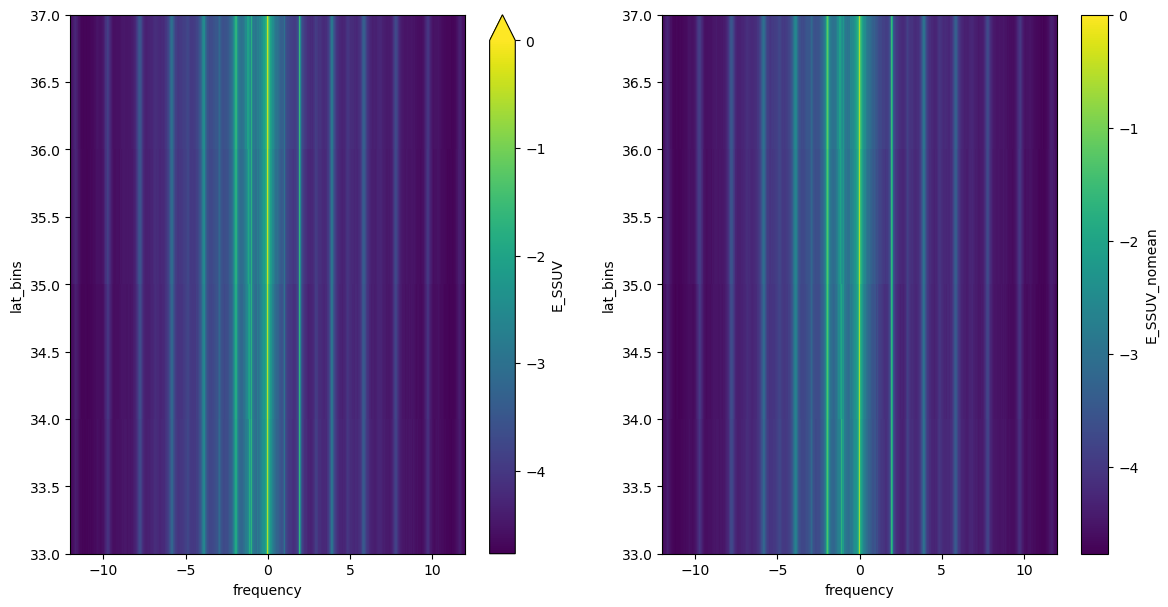

In [29]:
fig, axs = plt.subplots(1,len(dsE_Cal.keys()),figsize=(len(dsE_Cal.keys())*7,7))
for V,ax in zip(dsE_Cal.keys(),axs):
    np.log10(dsE_Cal[V]).plot(ax=ax,y='lat_bins',vmax=0)

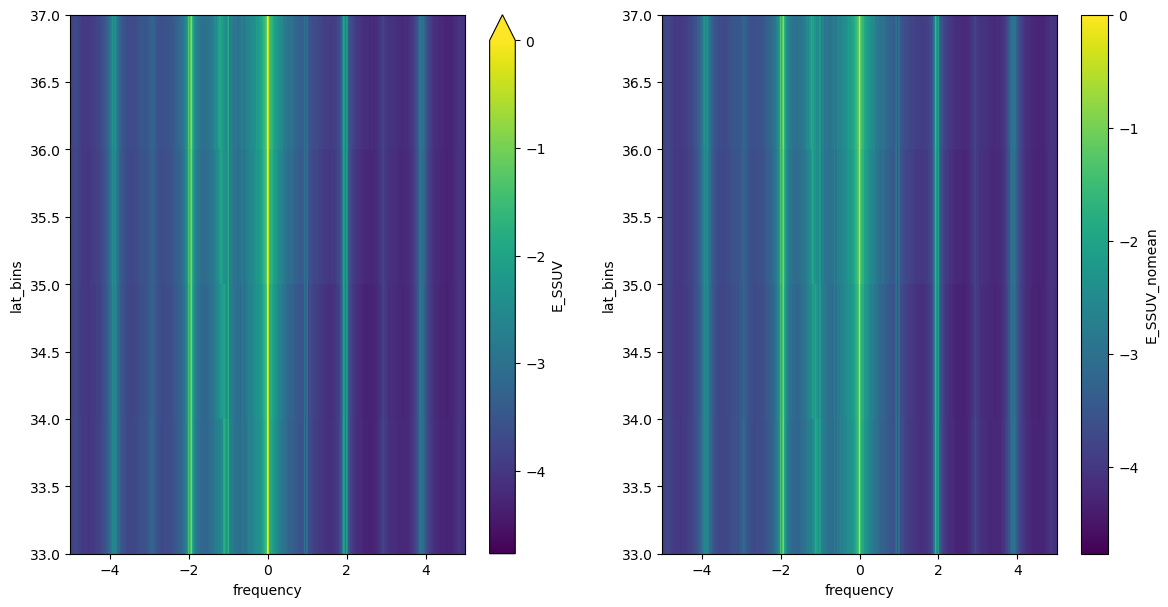

In [30]:
fig, axs = plt.subplots(1,len(dsE_Cal.keys()),figsize=(len(dsE_Cal.keys())*7,7))
for V,ax in zip(dsE_Cal.keys(),axs):
    np.log10(dsE_Cal[V]).plot(ax=ax,y='lat_bins',vmax=0)
    ax.set_xlim(-5,5)

(-5.0, 5.0)

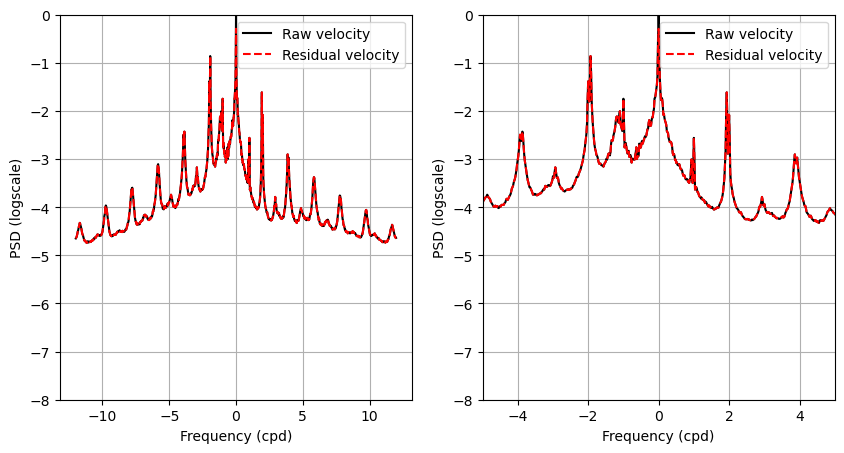

In [31]:
colors=['k','r','g']
styles=['-','--','-.']
labels=['Raw velocity','Residual velocity']
fig, ax = plt.subplots(1,2,figsize=(10,5))
for V,c,style in zip(dsE_Cal.keys(),colors,styles):
    np.log10(dsE_Cal[V].mean(dim='lat_bins',skipna=True)).plot(ax=ax[0],c=c,linestyle=style)
    np.log10(dsE_Cal[V].mean(dim='lat_bins',skipna=True)).plot(ax=ax[1],c=c,linestyle=style)
for a in ax:
    a.grid();a.set_ylim(-8,0);a.set_ylabel('PSD (logscale)')
    a.set_xlabel('Frequency (cpd)');
    a.legend(labels)
ax[1].set_xlim(-5,5)

#### Comparison E/L

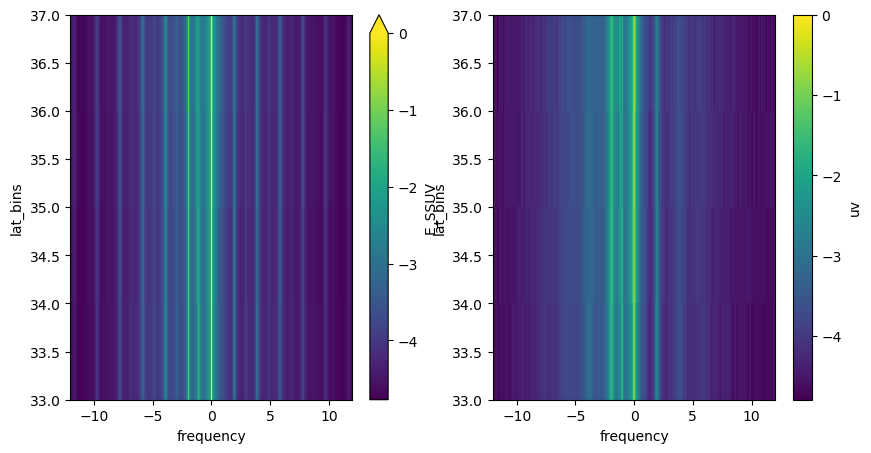

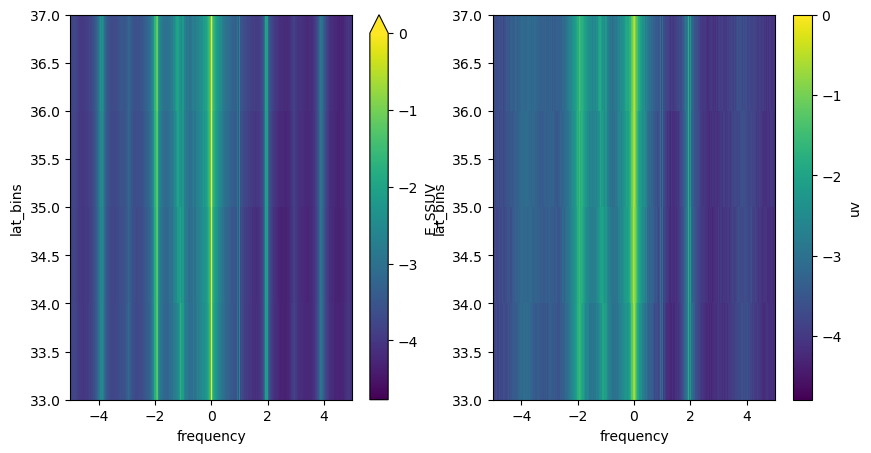

In [70]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
np.log10(dsE_Cal['E_SSUV']).plot(y='lat_bins',ax=ax[0],vmax=0)
np.log10(ds_Cal['uv']).plot(y='lat_bins',ax=ax[1],vmax=0)

fig,ax = plt.subplots(1,2,figsize=(10,5))
np.log10(dsE_Cal['E_SSUV']).plot(y='lat_bins',ax=ax[0],vmax=0)
np.log10(ds_Cal['uv']).plot(y='lat_bins',ax=ax[1],vmax=0)
for a in ax:
    a.set_xlim(-5,5)

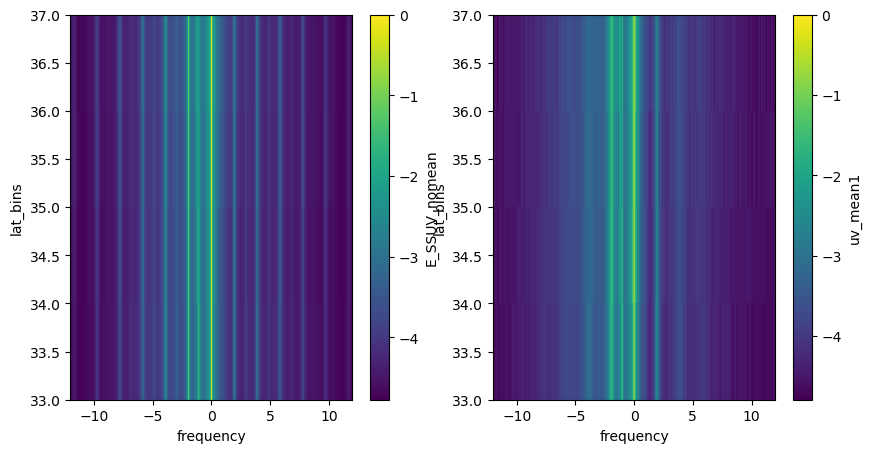

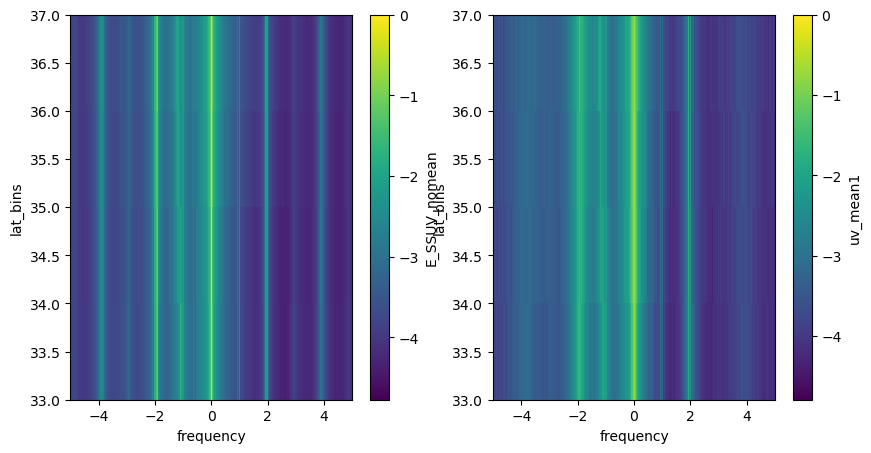

In [69]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
np.log10(dsE_Cal['E_SSUV_nomean']).plot(y='lat_bins',ax=ax[0],vmax=0)
np.log10(ds_Cal['uv_mean1']).plot(y='lat_bins',ax=ax[1],vmax=0)

fig,ax = plt.subplots(1,2,figsize=(10,5))
np.log10(dsE_Cal['E_SSUV_nomean']).plot(y='lat_bins',ax=ax[0],vmax=0)
np.log10(ds_Cal['uv_mean1']).plot(y='lat_bins',ax=ax[1],vmax=0)
for a in ax:
    a.set_xlim(-5,5)

(-5.0, 5.0)

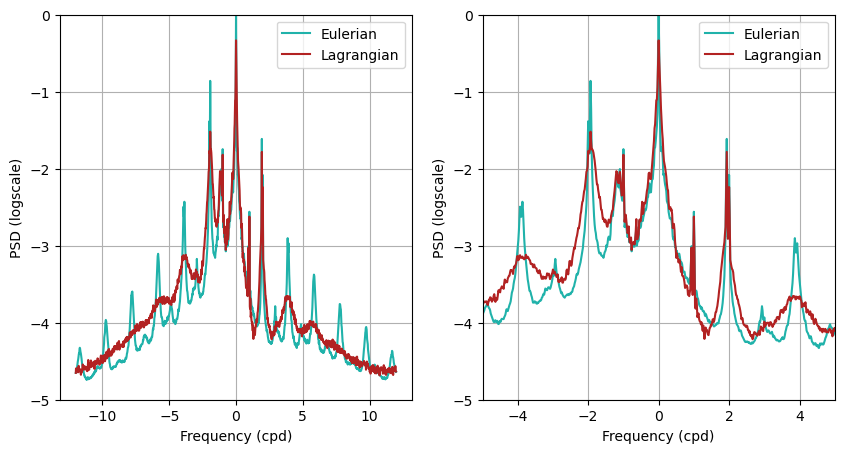

In [32]:
#colors=['k','r','g']
colors=['lightseagreen','firebrick']
styles=['-','--','-.']
labels=['Raw velocity','Residual velocity','Mean velocity']
fig, ax = plt.subplots(1,2,figsize=(10,5))
#for V,c,style in zip(dsE_Cal.keys(),colors,styles):
np.log10(dsE_Cal['E_SSUV'].mean(dim='lat_bins',skipna=True)).plot(ax=ax[0],c=colors[0],linestyle=styles[0])
np.log10(dsE_Cal['E_SSUV'].mean(dim='lat_bins',skipna=True)).plot(ax=ax[1],c=colors[0],linestyle=styles[0])
np.log10(ds_Cal['uv'].mean(dim='lat_bins',skipna=True)).plot(ax=ax[0],c=colors[1],linestyle=styles[0])
np.log10(ds_Cal['uv'].mean(dim='lat_bins',skipna=True)).plot(ax=ax[1],c=colors[1],linestyle=styles[0])
for a in ax:
    a.grid();a.set_ylim(-5,0);a.set_ylabel('PSD (logscale)')
    a.set_xlabel('Frequency (cpd)');
    a.legend(['Eulerian','Lagrangian'])
ax[1].set_xlim(-5,5)

(-5.0, 5.0)

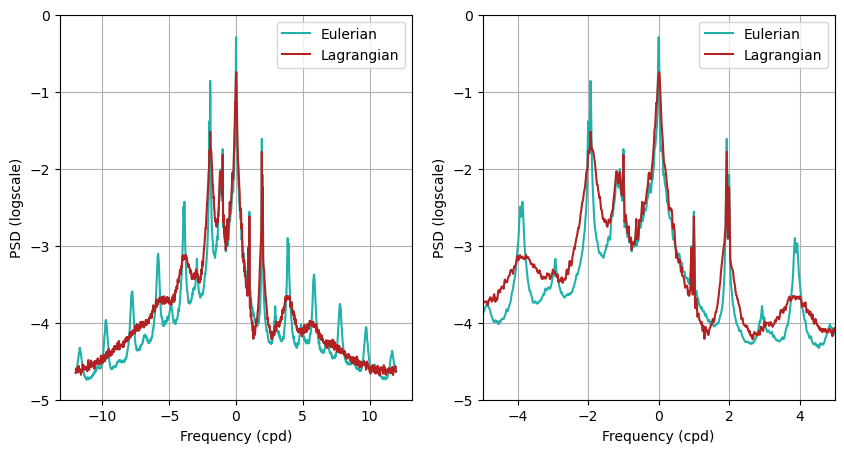

In [33]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
#for V,c,style in zip(dsE_Cal.keys(),colors,styles):
np.log10(dsE_Cal['E_SSUV_nomean'].mean(dim='lat_bins',skipna=True)).plot(ax=ax[0],c=colors[0],linestyle=styles[0])
np.log10(dsE_Cal['E_SSUV_nomean'].mean(dim='lat_bins',skipna=True)).plot(ax=ax[1],c=colors[0],linestyle=styles[0])
np.log10(ds_Cal['uv_mean1'].mean(dim='lat_bins',skipna=True)).plot(ax=ax[0],c=colors[1],linestyle=styles[0])
np.log10(ds_Cal['uv_mean1'].mean(dim='lat_bins',skipna=True)).plot(ax=ax[1],c=colors[1],linestyle=styles[0])
for a in ax:
    a.grid();a.set_ylim(-5,0);a.set_ylabel('PSD (logscale)')
    a.set_xlabel('Frequency (cpd)');
    a.legend(['Eulerian','Lagrangian'])
ax[1].set_xlim(-5,5)

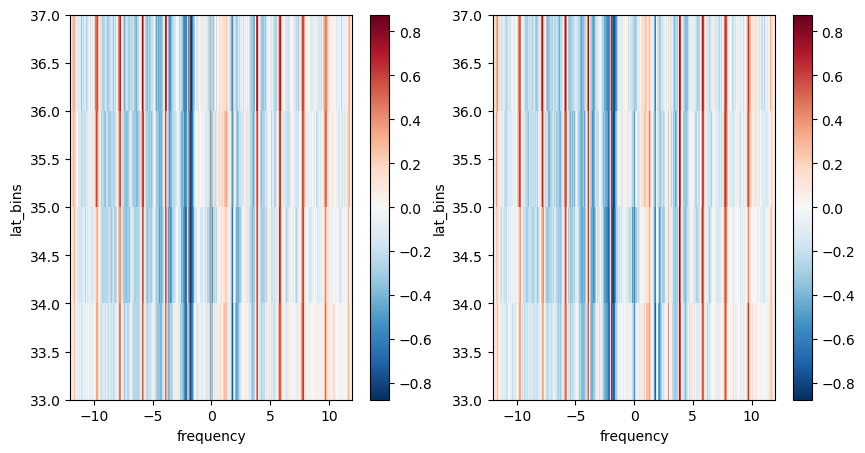

In [34]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
np.log10(dsE_Cal['E_SSUV']/ds_Cal['uv']).plot(y='lat_bins',cmap='RdBu_r',ax=ax[0])
np.log10(dsE_Cal['E_SSUV_nomean']/ds_Cal['uv_mean1']).plot(y='lat_bins',cmap='RdBu_r',ax=ax[1])

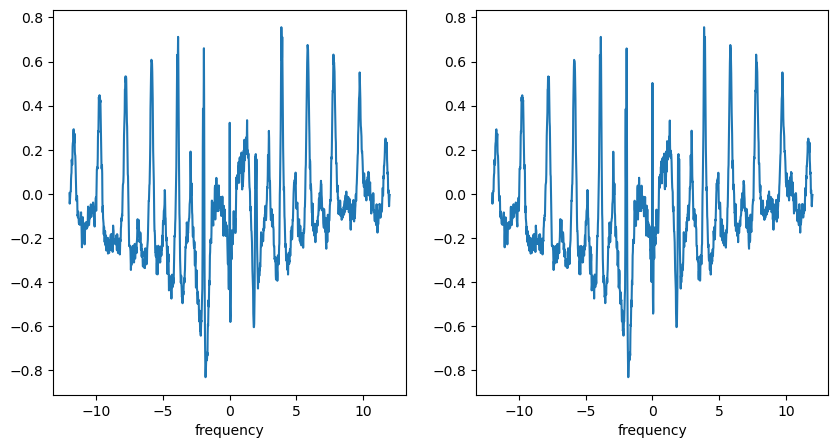

In [35]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
np.log10(dsE_Cal['E_SSUV'].mean('lat_bins')/ds_Cal['uv'].mean('lat_bins')).plot(ax=ax[0])
np.log10(dsE_Cal['E_SSUV_nomean'].mean('lat_bins')/ds_Cal['uv_mean1'].mean('lat_bins')).plot(ax=ax[1])

#### Mediterranean sea

In [36]:
bbox = [-2, 8, 36, 45] # large bbox


In [37]:
df_mean0_Med = binned_spectra_site(bbox,df_Lspectra_mean0,dl);
df_mean1_Med = binned_spectra_site(bbox,df_Lspectra_mean1,dl);
df_mean2_Med = binned_spectra_site(bbox,df_Lspectra_mean2,dl);

In [38]:
ds_Med = xr.merge([df_mean0_Med,df_mean1_Med.uv.rename('uv_mean1')
                   ,df_mean2_Med.uv.rename('uv_mean2')])

In [39]:
dsE_Med = binned_Espectra_site(bbox,ds_E,dl)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [40]:
dsE_Med_nomean = binned_Espectra_site(bbox,ds_E_nomean,dl)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [41]:
dsE_Med_nomean.name = 'E_SSUV_nomean'

dsE_Med = xr.merge([dsE_Med,dsE_Med_nomean])

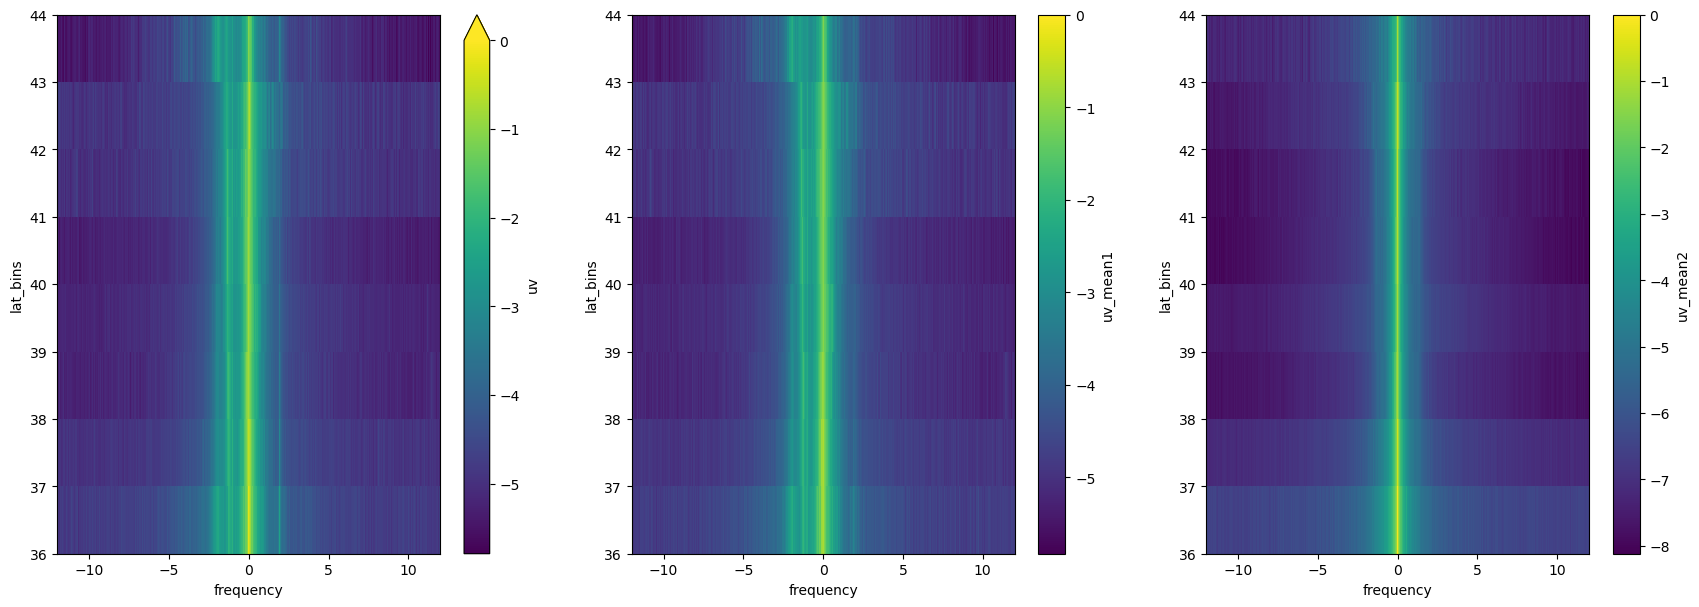

In [42]:
fig, axs = plt.subplots(1,len(ds_Med.keys()),figsize=(len(ds_Med.keys())*7,7))
for V,ax in zip(ds_Med.keys(),axs):
    np.log10(ds_Med[V]).plot(ax=ax,cmap='viridis',vmax=0)

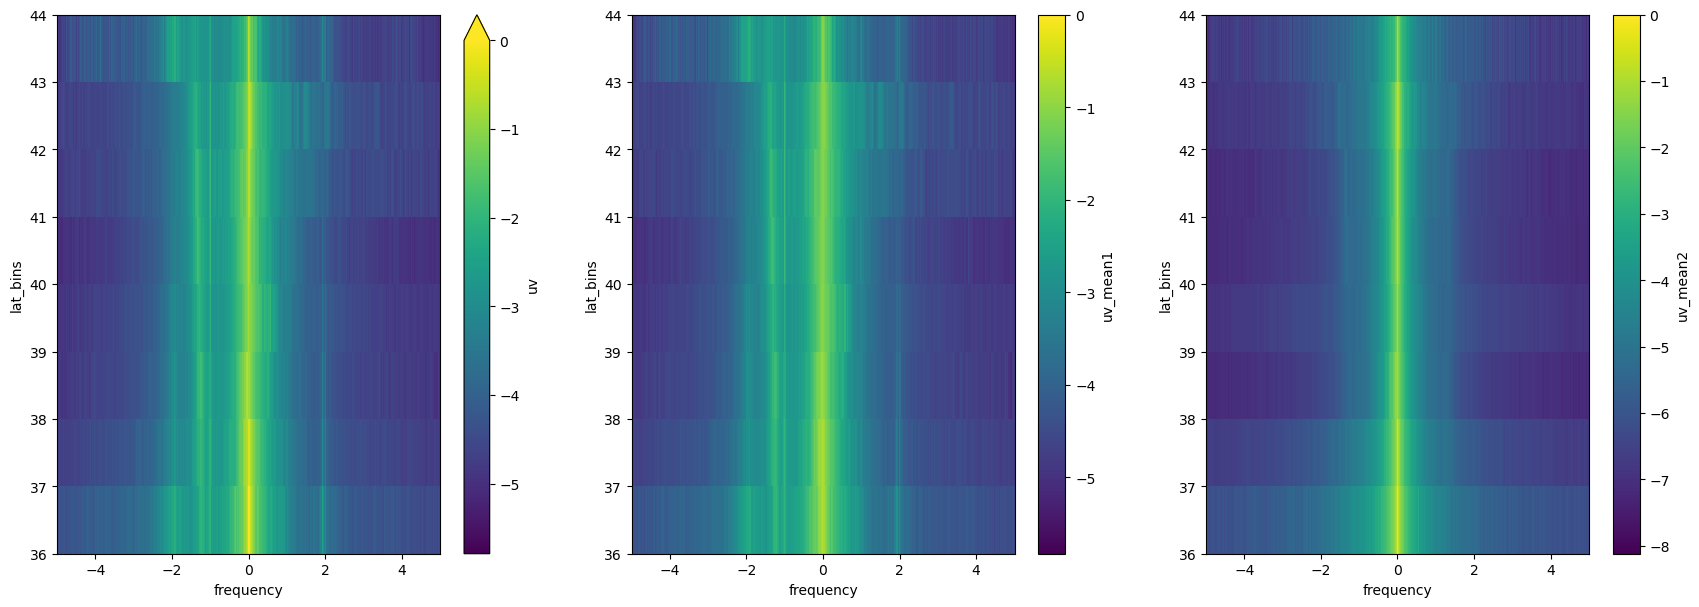

In [43]:
fig, axs = plt.subplots(1,len(ds_Med.keys()),figsize=(len(ds_Med.keys())*7,7))
for V,ax in zip(ds_Med.keys(),axs):
    np.log10(ds_Med[V]).plot(ax=ax,cmap='viridis',vmax=0)
    ax.set_xlim(-5,5)

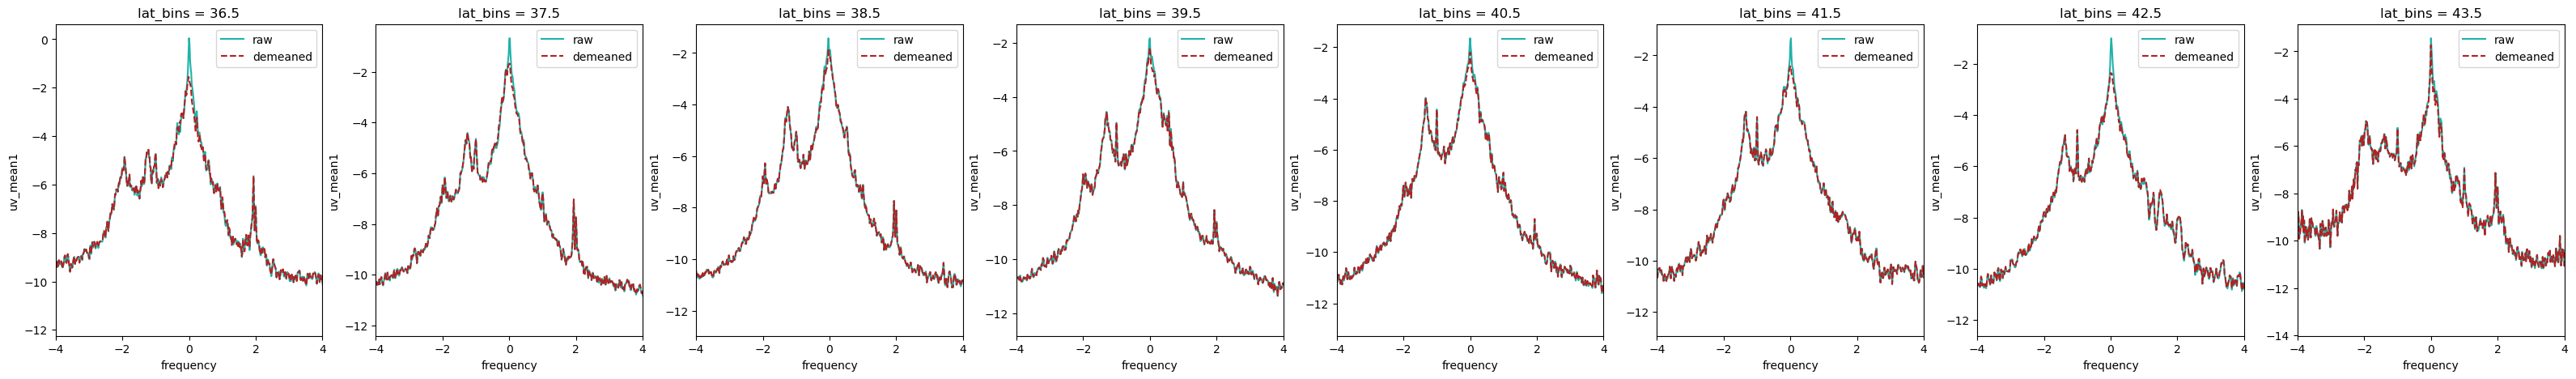

In [46]:
labels = ['raw', 'demeaned','mean']
fig,axs = plt.subplots(1,len(ds_Med.lat_bins.values),figsize=(len(ds_Med.lat_bins.values)*5,5))
for V,c,style in zip(ds_Med.keys(),colors,styles):
    for i,ax in enumerate(axs):
    
        np.log(ds_Med[V].isel(lat_bins=i)).plot(c=c,linestyle=style,ax=ax
                                               )
        ax.set_xlim(-4,4)
        ax.legend(labels)
        ax.grid()

(-5.0, 5.0)

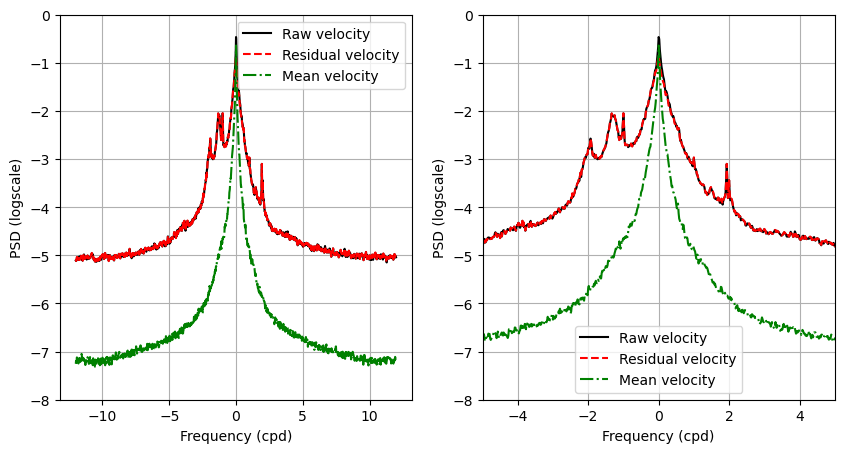

In [101]:
colors=['k','r','g']
styles=['-','--','-.']
labels=['Raw velocity','Residual velocity','Mean velocity']
fig, ax = plt.subplots(1,2,figsize=(10,5))
for V,c,style in zip(ds_Med.keys(),colors,styles):
    np.log10(ds_Med[V].mean(['lat_bins'])).plot(ax=ax[0],c=c,linestyle=style)
    np.log10(ds_Med[V].mean(['lat_bins'])).plot(ax=ax[1],c=c,linestyle=style)
for a in ax:
    a.grid();a.set_ylim(-8,0);a.set_ylabel('PSD (logscale)')
    a.set_xlabel('Frequency (cpd)');
    a.legend(labels)
ax[1].set_xlim(-5,5)

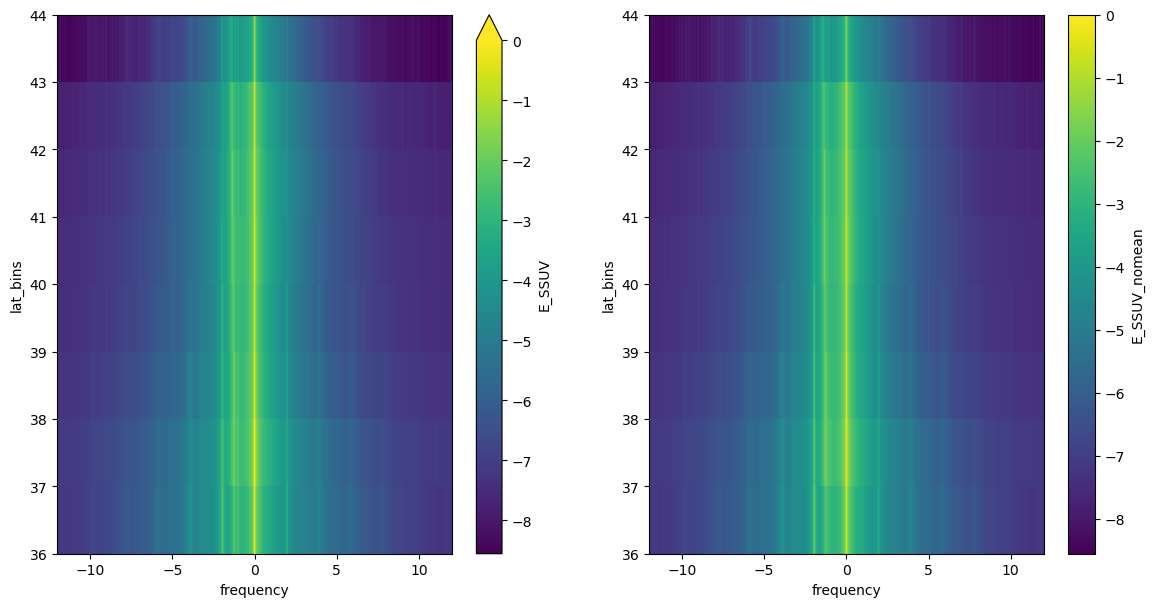

In [48]:
fig, axs = plt.subplots(1,len(dsE_Med.keys()),figsize=(len(dsE_Med.keys())*7,7))
for V,ax in zip(dsE_Med.keys(),axs):
    np.log10(dsE_Med[V]).plot(ax=ax,y='lat_bins',vmax=0)

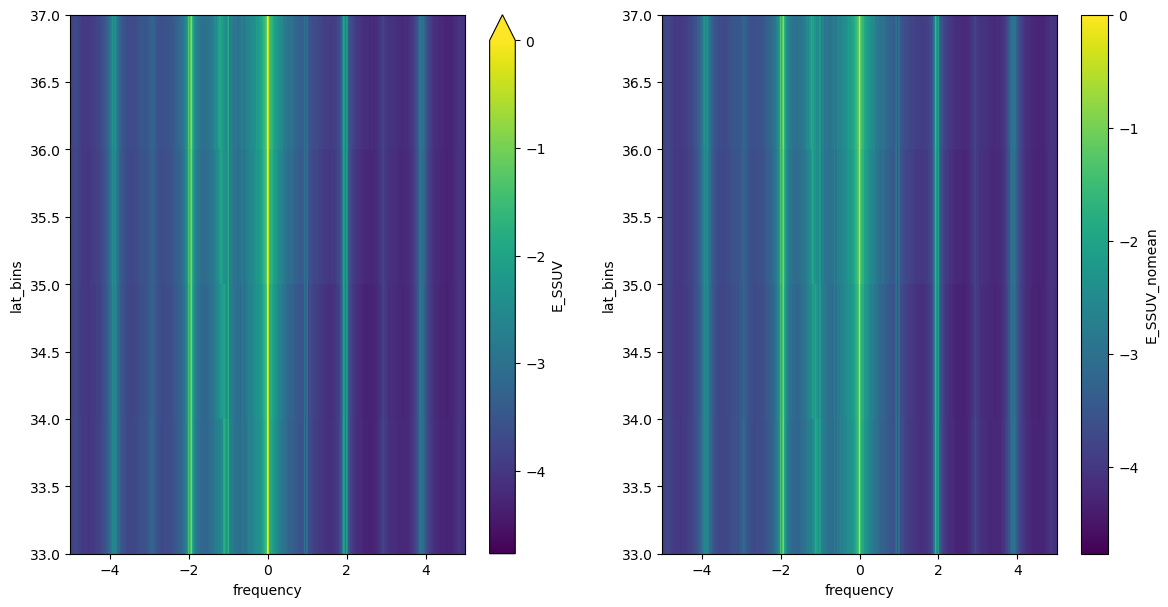

In [49]:
fig, axs = plt.subplots(1,len(dsE_Cal.keys()),figsize=(len(dsE_Cal.keys())*7,7))
for V,ax in zip(dsE_Cal.keys(),axs):
    np.log10(dsE_Cal[V]).plot(ax=ax,y='lat_bins',vmax=0)
    ax.set_xlim(-5,5)

(-5.0, 5.0)

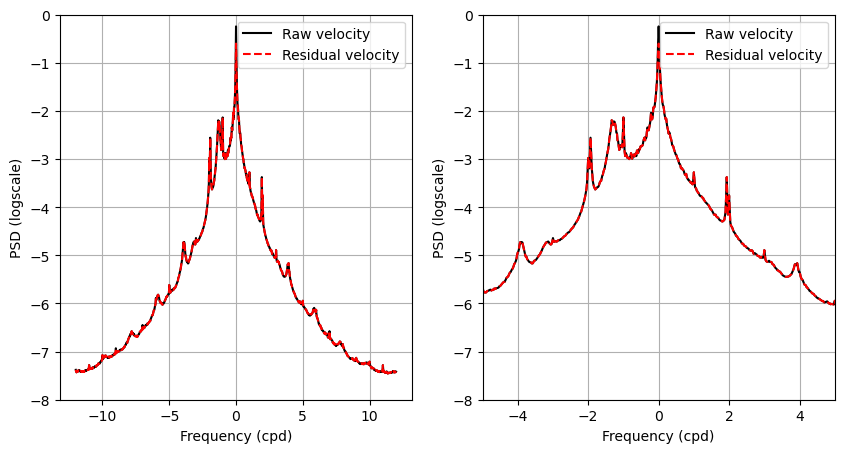

In [54]:
colors=['k','r','g']
styles=['-','--','-.']
labels=['Raw velocity','Residual velocity','Mean velocity']
fig, ax = plt.subplots(1,2,figsize=(10,5))
for V,c,style in zip(dsE_Med.keys(),colors,styles):
    np.log10(dsE_Med[V].mean(dim='lat_bins',skipna=True)).plot(ax=ax[0],c=c,linestyle=style)
    np.log10(dsE_Med[V].mean(dim='lat_bins',skipna=True)).plot(ax=ax[1],c=c,linestyle=style)
for a in ax:
    a.grid();a.set_ylim(-8,0);a.set_ylabel('PSD (logscale)')
    a.set_xlabel('Frequency (cpd)');
    a.legend(labels)
ax[1].set_xlim(-5,5)

#### Compariaon E/L:

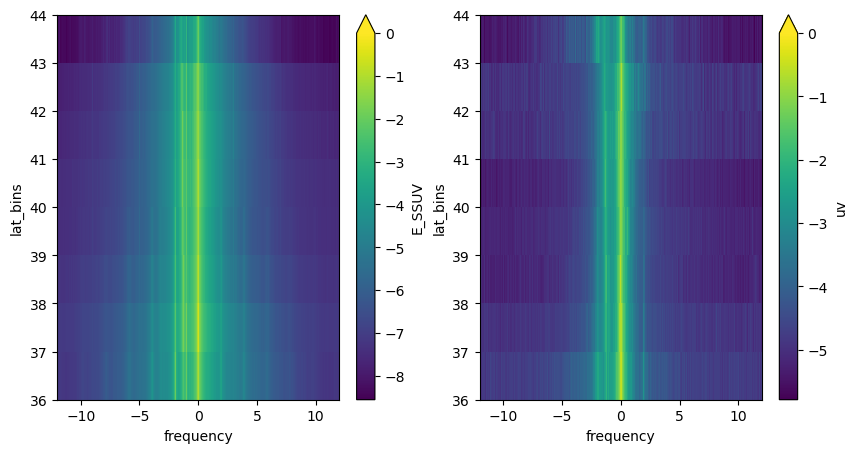

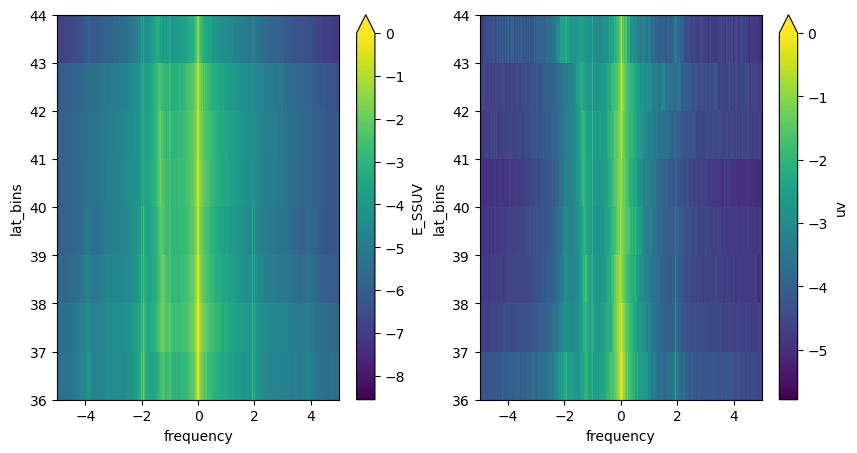

In [65]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
np.log10(dsE_Med['E_SSUV']).plot(y='lat_bins',ax=ax[0],vmax=0)
np.log10(ds_Med['uv']).plot(y='lat_bins',ax=ax[1],vmax=0)

fig,ax = plt.subplots(1,2,figsize=(10,5))
np.log10(dsE_Med['E_SSUV']).plot(y='lat_bins',ax=ax[0],vmax=0)
np.log10(ds_Med['uv']).plot(y='lat_bins',ax=ax[1],vmax=0)
for a in ax:
    a.set_xlim(-5,5)

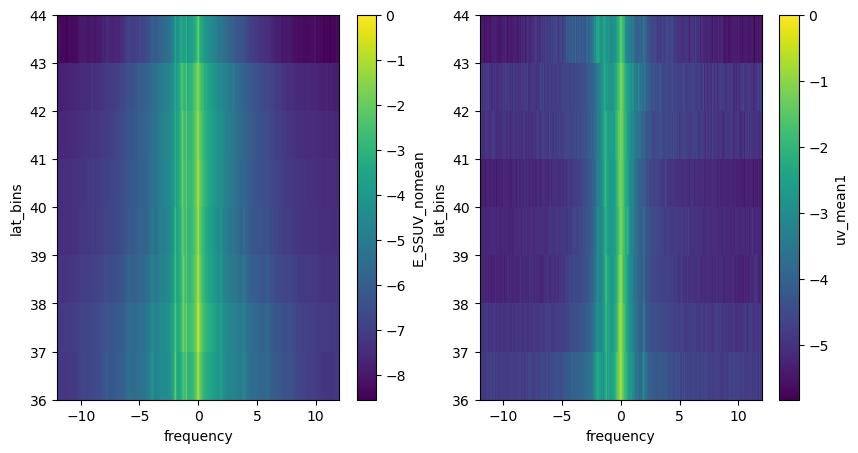

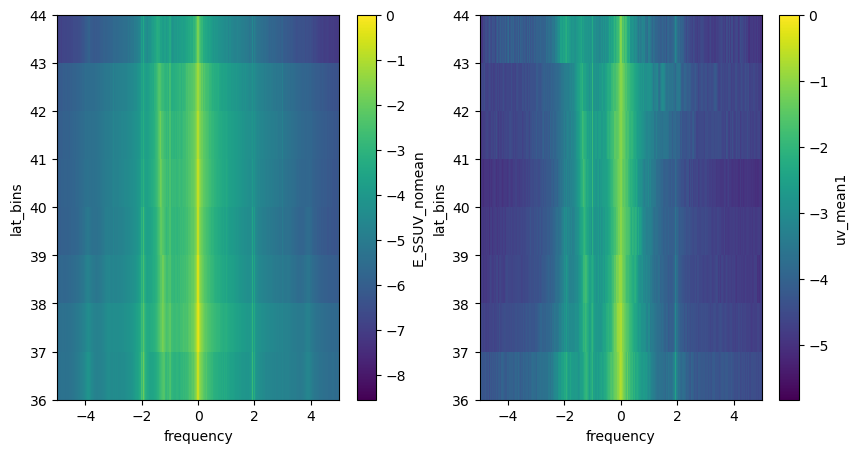

In [66]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
np.log10(dsE_Med['E_SSUV_nomean']).plot(y='lat_bins',ax=ax[0],vmax=0)
np.log10(ds_Med['uv_mean1']).plot(y='lat_bins',ax=ax[1],vmax=0)

fig,ax = plt.subplots(1,2,figsize=(10,5))
np.log10(dsE_Med['E_SSUV_nomean']).plot(y='lat_bins',ax=ax[0],vmax=0)
np.log10(ds_Med['uv_mean1']).plot(y='lat_bins',ax=ax[1],vmax=0)
for a in ax:
    a.set_xlim(-5,5)

(-5.0, 5.0)

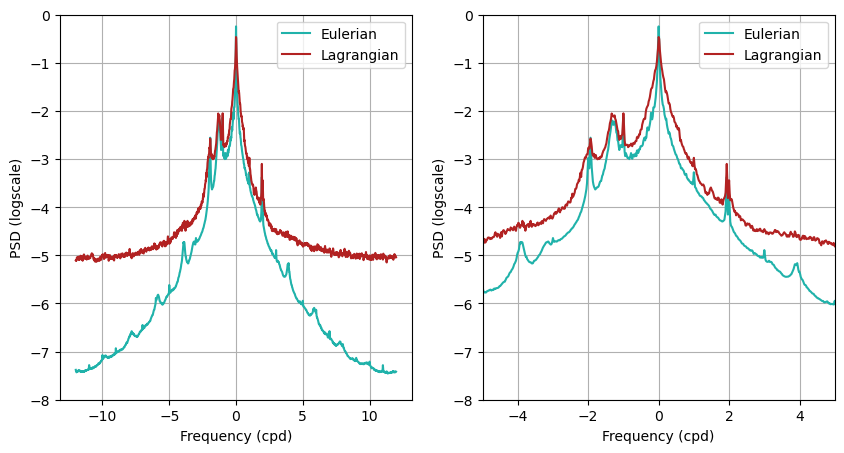

In [52]:
#colors=['k','r','g']
colors=['lightseagreen','firebrick']
styles=['-','--','-.']
labels=['Raw velocity','Residual velocity','Mean velocity']
fig, ax = plt.subplots(1,2,figsize=(10,5))
#for V,c,style in zip(dsE_Cal.keys(),colors,styles):
np.log10(dsE_Med['E_SSUV'].mean(dim='lat_bins',skipna=True)).plot(ax=ax[0],c=colors[0],linestyle=styles[0])
np.log10(dsE_Med['E_SSUV'].mean(dim='lat_bins',skipna=True)).plot(ax=ax[1],c=colors[0],linestyle=styles[0])
np.log10(ds_Med['uv'].mean(dim='lat_bins',skipna=True)).plot(ax=ax[0],c=colors[1],linestyle=styles[0])
np.log10(ds_Med['uv'].mean(dim='lat_bins',skipna=True)).plot(ax=ax[1],c=colors[1],linestyle=styles[0])
for a in ax:
    a.grid();a.set_ylim(-8,0);a.set_ylabel('PSD (logscale)')
    a.set_xlabel('Frequency (cpd)');
    a.legend(['Eulerian','Lagrangian'])
ax[1].set_xlim(-5,5)

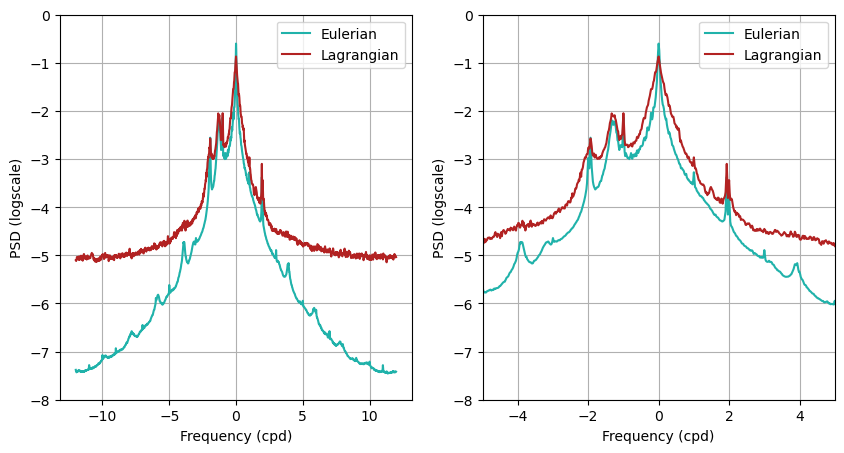

In [53]:
#colors=['k','r','g']
colors=['lightseagreen','firebrick']
styles=['-','--','-.']
labels=['Raw velocity','Residual velocity','Mean velocity']
fig, ax = plt.subplots(1,2,figsize=(10,5))
#for V,c,style in zip(dsE_Cal.keys(),colors,styles):
np.log10(dsE_Med['E_SSUV_nomean'].mean(dim='lat_bins',skipna=True)).plot(ax=ax[0],c=colors[0],linestyle=styles[0])
np.log10(dsE_Med['E_SSUV_nomean'].mean(dim='lat_bins',skipna=True)).plot(ax=ax[1],c=colors[0],linestyle=styles[0])
np.log10(ds_Med['uv_mean1'].mean(dim='lat_bins',skipna=True)).plot(ax=ax[0],c=colors[1],linestyle=styles[0])
np.log10(ds_Med['uv_mean1'].mean(dim='lat_bins',skipna=True)).plot(ax=ax[1],c=colors[1],linestyle=styles[0])
for a in ax:
    a.grid();a.set_ylim(-8,0);a.set_ylabel('PSD (logscale)')
    a.set_xlabel('Frequency (cpd)');
    a.legend(['Eulerian','Lagrangian'])
    ax[1].set_xlim(-5,5)

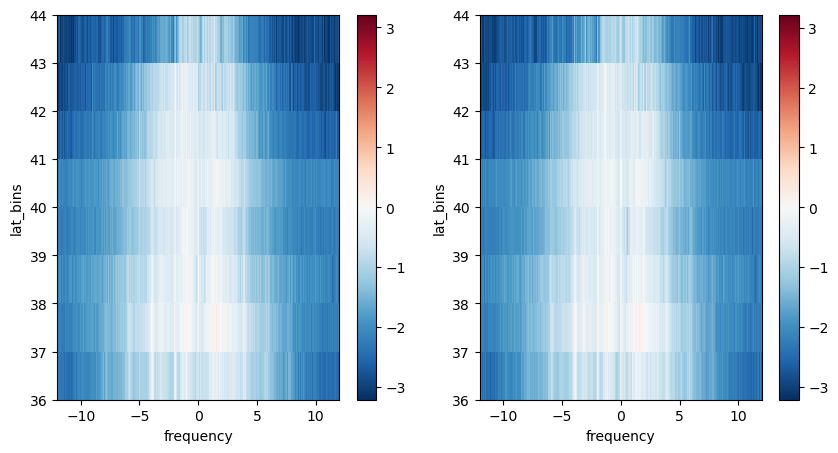

In [56]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
np.log10(dsE_Med['E_SSUV']/ds_Med['uv']).plot(y='lat_bins',cmap='RdBu_r',ax=ax[0])
np.log10(dsE_Med['E_SSUV_nomean']/ds_Med['uv_mean1']).plot(y='lat_bins',cmap='RdBu_r',ax=ax[1])

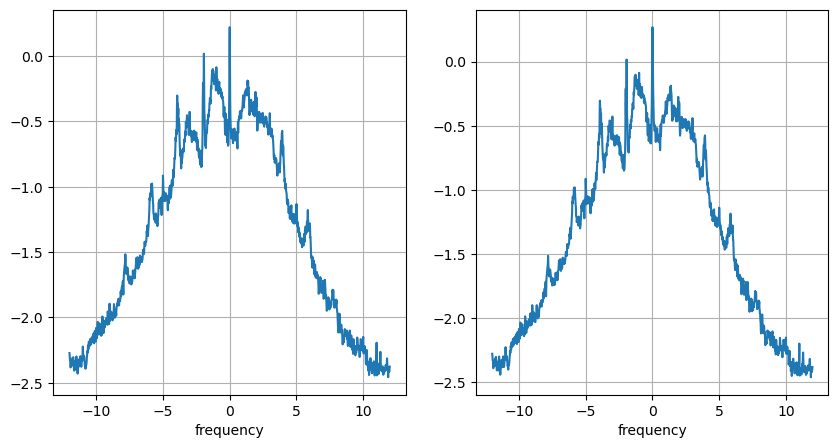

In [60]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
np.log10(dsE_Med['E_SSUV'].mean('lat_bins')/ds_Med['uv'].mean('lat_bins')).plot(ax=ax[0])
np.log10(dsE_Med['E_SSUV_nomean'].mean('lat_bins')/ds_Med['uv_mean1'].mean('lat_bins')).plot(ax=ax[1])
for a in ax :
    a.grid() 

#### North west Australia

In [67]:
bbox = [120, 126, -20, -10]

In [68]:
df_mean0_NWA = binned_spectra_site(bbox,df_Lspectra_mean0,dl);
df_mean1_NWA = binned_spectra_site(bbox,df_Lspectra_mean1,dl);
df_mean2_NWA = binned_spectra_site(bbox,df_Lspectra_mean2,dl);

In [71]:
ds_NWA = xr.merge([df_mean0_NWA,df_mean1_NWA.uv.rename('uv_mean1')
                   ,df_mean2_NWA.uv.rename('uv_mean2')])

In [73]:
dsE_NWA = binned_Espectra_site(bbox,ds_E,dl)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]


In [74]:
dsE_NWA_nomean = binned_Espectra_site(bbox,ds_E_nomean,dl)

/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/xarray/core/indexing.py:1375: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  value = value[(slice(None),) * axis + (subkey,)]
distributed.core - ERROR - Exception while handling op heartbeat_worker
Traceback (most recent call last):
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/core.py", line 497, in handle_comm
    result = handler(comm, **msg)
  File "/home1/datahome/zcaspar/miniconda3/envs/croco/lib/python3.8/site-packages/distributed/scheduler.py", line 3820, in heartbeat_worker
    ws._executing = {
  File "/home1/datahome/zcaspar

In [75]:
dsE_NWA_nomean.name = 'E_SSUV_nomean'

dsE_NWA = xr.merge([dsE_NWA,dsE_NWA_nomean])

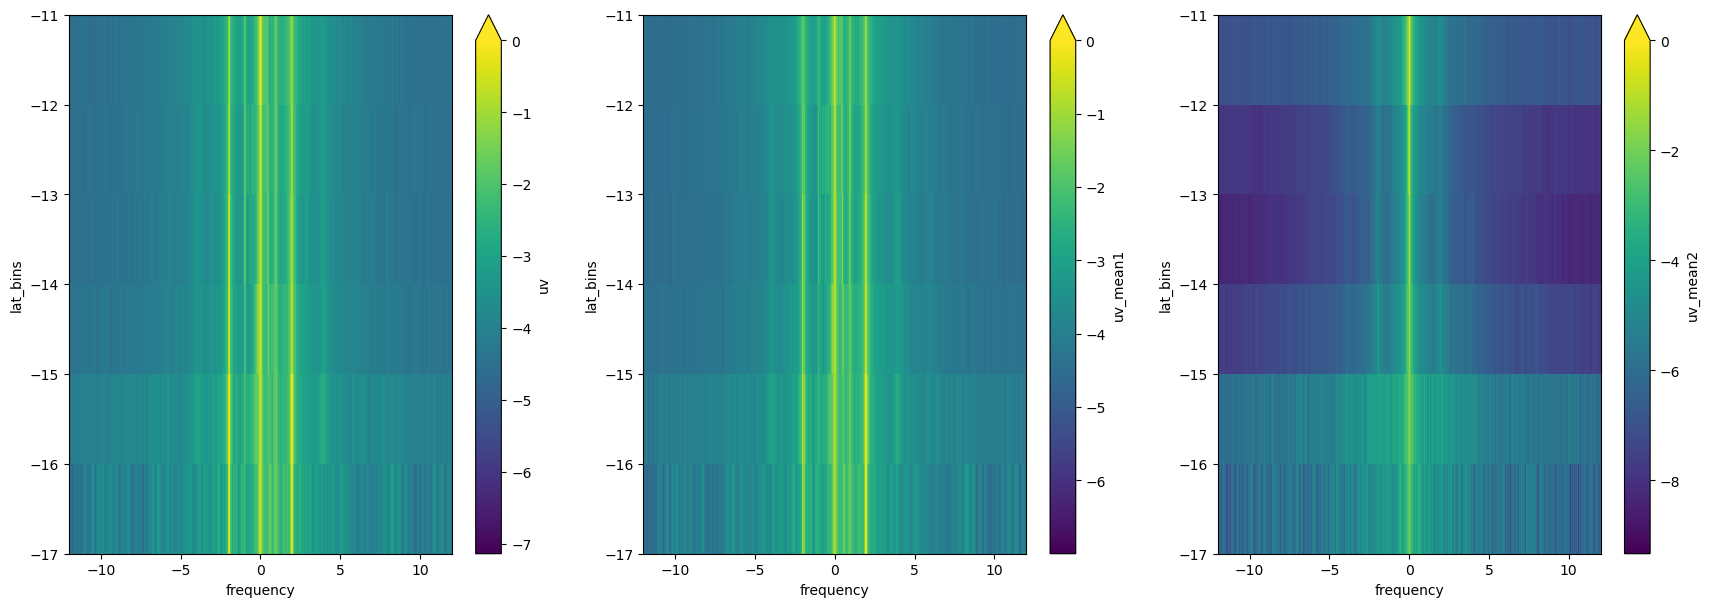

In [83]:
fig, axs = plt.subplots(1,len(ds_NWA.keys()),figsize=(len(ds_NWA.keys())*7,7))
for V,ax in zip(ds_NWA.keys(),axs):
    np.log10(ds_NWA[V]).plot(ax=ax,cmap='viridis',vmax=0)
    ax.set_ylim(-17,-11)

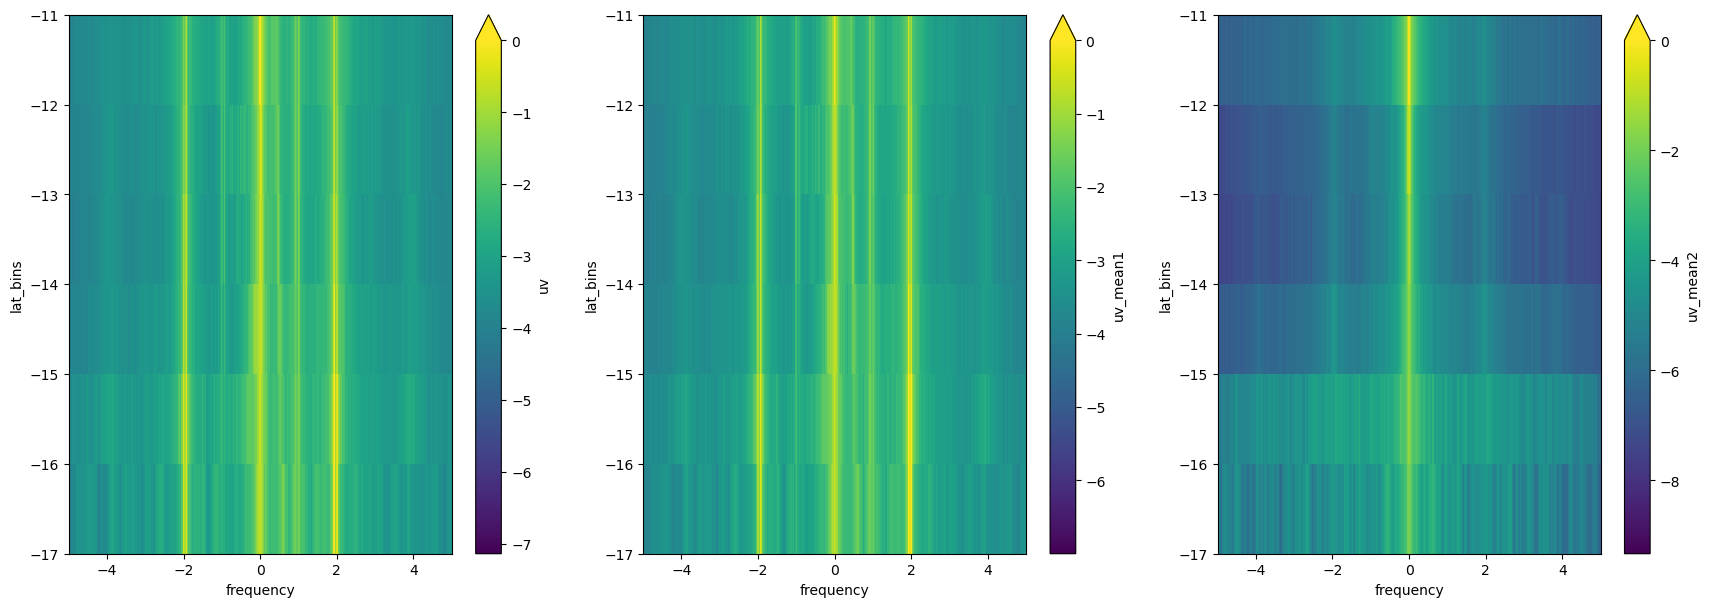

In [82]:
fig, axs = plt.subplots(1,len(ds_NWA.keys()),figsize=(len(ds_NWA.keys())*7,7))
for V,ax in zip(ds_NWA.keys(),axs):
    np.log10(ds_NWA[V]).plot(ax=ax,cmap='viridis',vmax=0)
    ax.set_xlim(-5,5);ax.set_ylim(-17,-11)

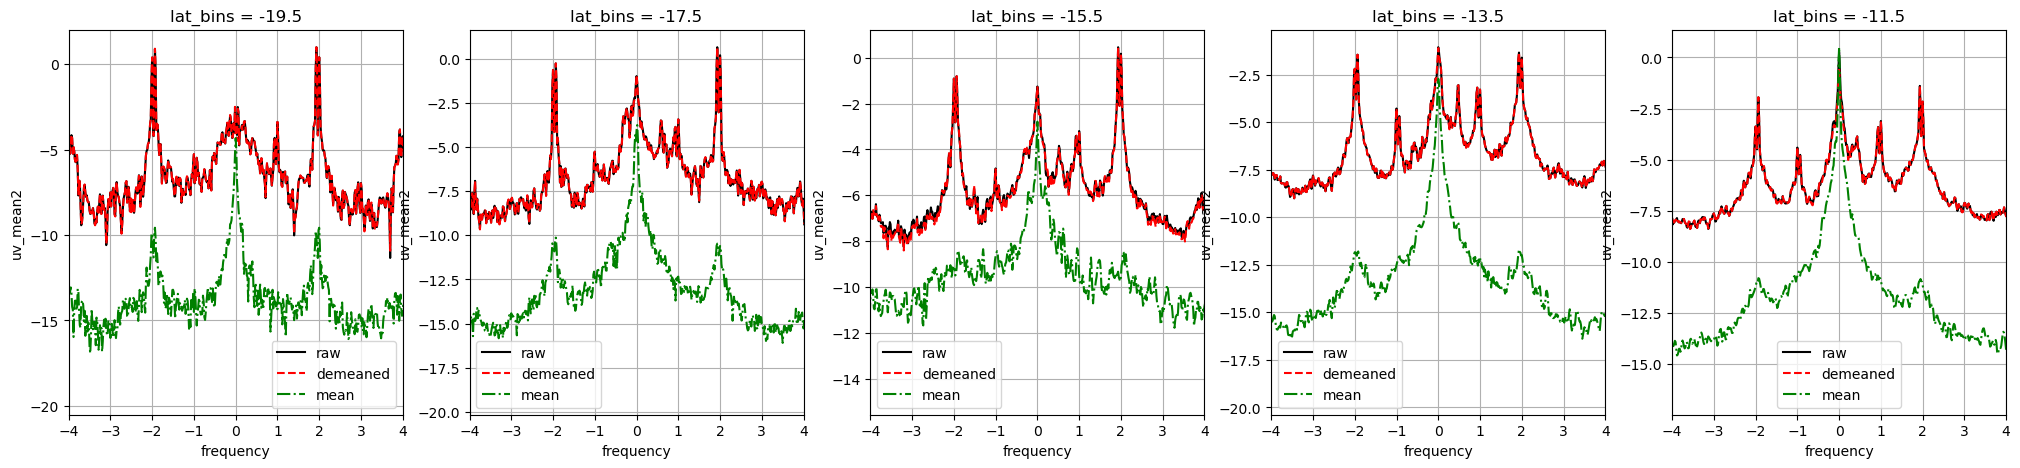

In [79]:
labels = ['raw', 'demeaned','mean']
fig,axs = plt.subplots(1,len(ds_NWA.lat_bins.values[::2]),figsize=(len(ds_NWA.lat_bins.values[::2])*5,5))
for V,c,style in zip(ds_NWA.keys(),colors,styles):
    for l,ax in zip(ds_NWA.lat_bins.values[::2],axs):
    
        np.log(ds_NWA[V].sel(lat_bins=l)).plot(c=c,linestyle=style,ax=ax
                                           )
        ax.set_xlim(-4,4)
        ax.legend(labels);ax.grid()

(-5.0, 5.0)

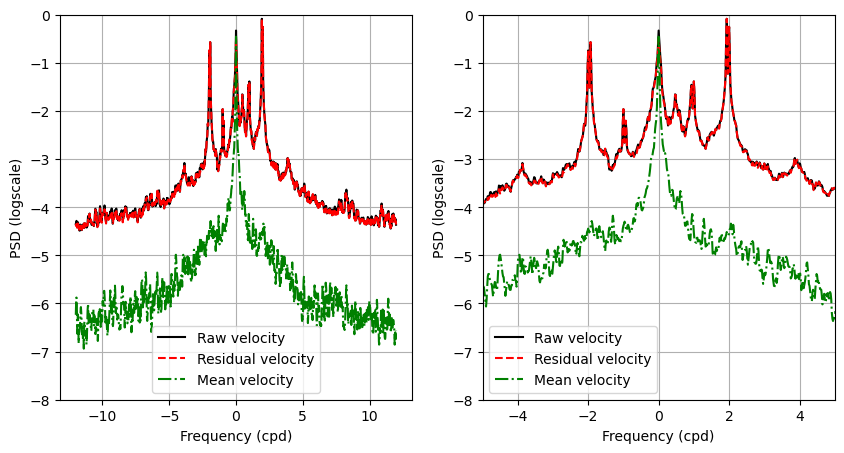

In [86]:
colors=['k','r','g']
styles=['-','--','-.']
labels=['Raw velocity','Residual velocity','Mean velocity']
fig, ax = plt.subplots(1,2,figsize=(10,5))
for V,c,style in zip(ds_NWA.keys(),colors,styles):
    np.log10(ds_NWA[V].sel(lat_bins=slice(-17,-11)).mean(['lat_bins'])).plot(ax=ax[0],c=c,linestyle=style)
    np.log10(ds_NWA[V].sel(lat_bins=slice(-17,-11)).mean(['lat_bins'])).plot(ax=ax[1],c=c,linestyle=style)
for a in ax:
    a.grid();a.set_ylim(-8,0);a.set_ylabel('PSD (logscale)')
    a.set_xlabel('Frequency (cpd)');
    a.legend(labels)
ax[1].set_xlim(-5,5)

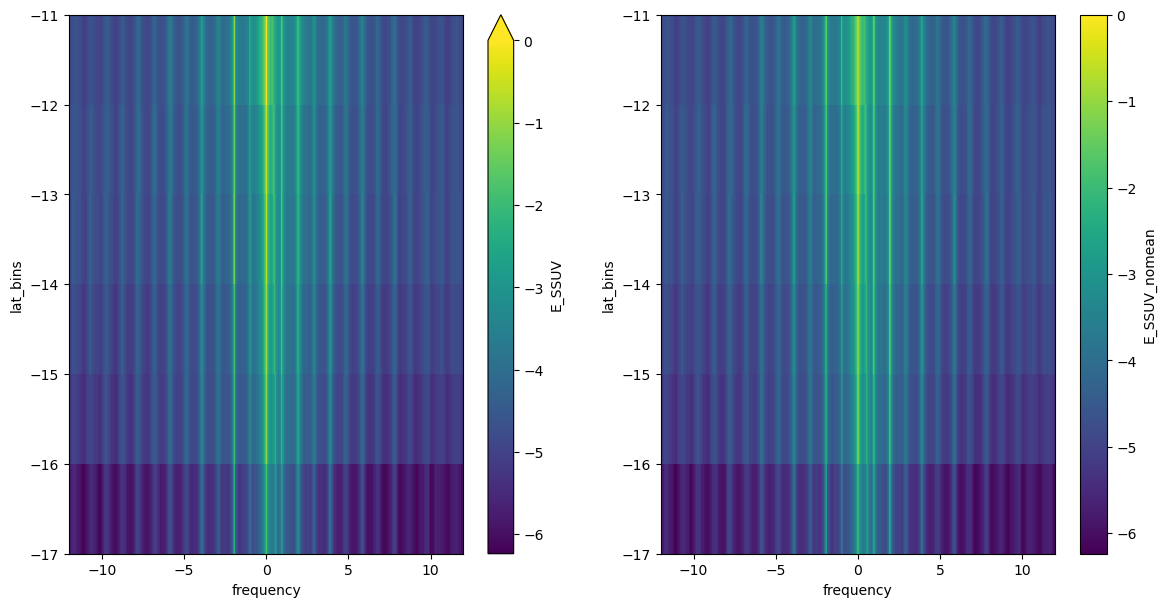

In [87]:
fig, axs = plt.subplots(1,len(dsE_NWA.keys()),figsize=(len(dsE_NWA.keys())*7,7))
for V,ax in zip(dsE_NWA.keys(),axs):
    np.log10(dsE_NWA[V]).plot(ax=ax,y='lat_bins',vmax=0)
    ax.set_ylim(-17,-11)

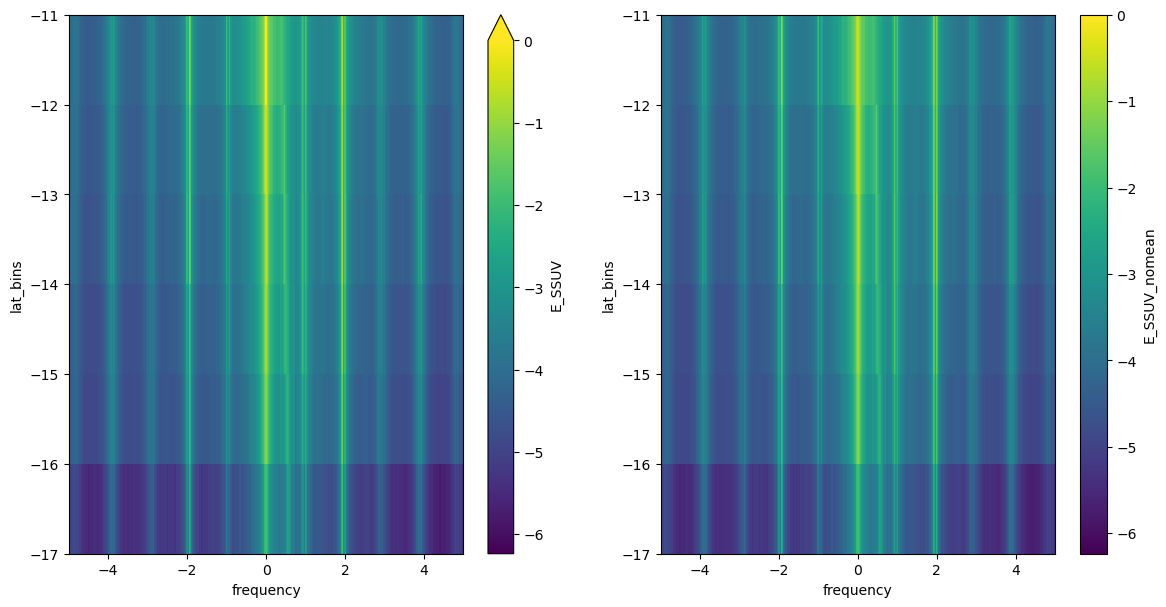

In [88]:
fig, axs = plt.subplots(1,len(dsE_NWA.keys()),figsize=(len(dsE_NWA.keys())*7,7))
for V,ax in zip(dsE_NWA.keys(),axs):
    np.log10(dsE_NWA[V]).plot(ax=ax,y='lat_bins',vmax=0)
    ax.set_xlim(-5,5);ax.set_ylim(-17,-11)

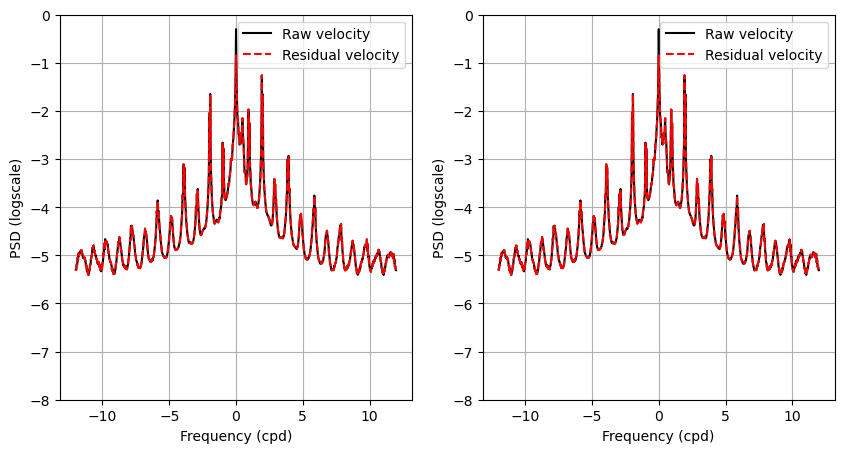

In [89]:
colors=['k','r','g']
styles=['-','--','-.']
labels=['Raw velocity','Residual velocity','Mean velocity']
fig, ax = plt.subplots(1,2,figsize=(10,5))
for V,c,style in zip(dsE_NWA.keys(),colors,styles):
    np.log10(dsE_NWA[V].mean(dim='lat_bins',skipna=True)).plot(ax=ax[0],c=c,linestyle=style)
    np.log10(dsE_NWA[V].mean(dim='lat_bins',skipna=True)).plot(ax=ax[1],c=c,linestyle=style)
for a in ax:
    a.grid();a.set_ylim(-8,0);a.set_ylabel('PSD (logscale)')
    a.set_xlabel('Frequency (cpd)');
    a.legend(labels)

#### Comparison E/L

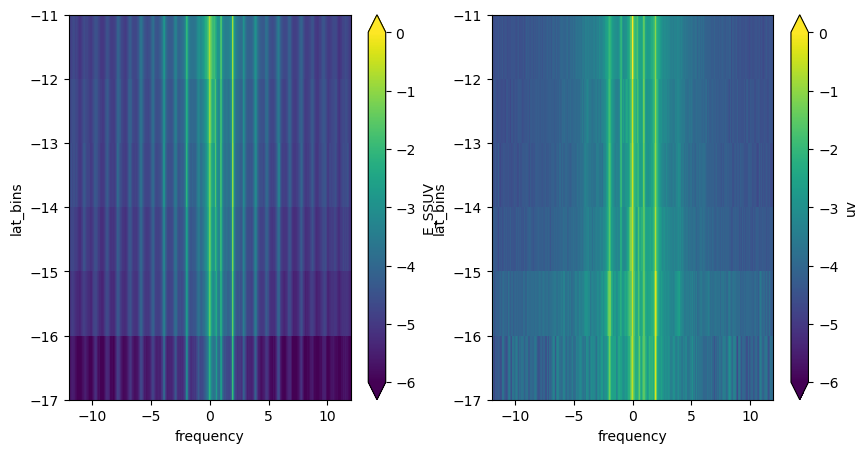

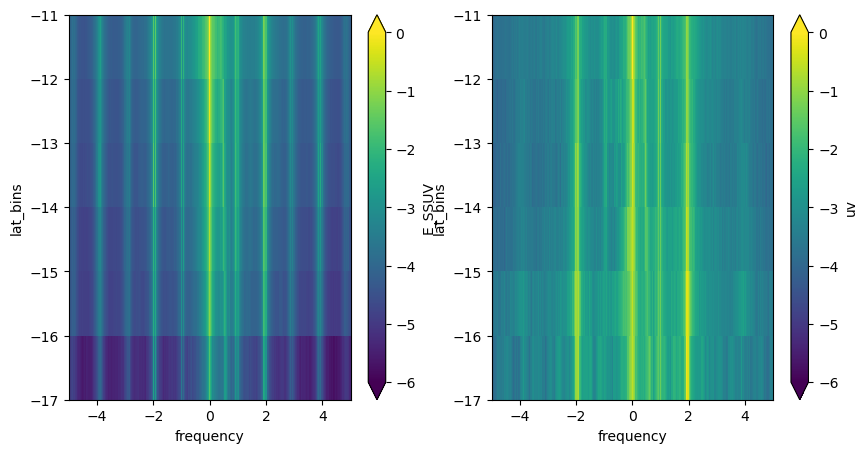

In [100]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
np.log10(dsE_NWA['E_SSUV']).plot(y='lat_bins',ax=ax[0],vmax=0,vmin=-6)
np.log10(ds_NWA['uv']).plot(y='lat_bins',ax=ax[1],vmax=0,vmin=-6)
for a in ax:
    a.set_ylim(-17,-11)
fig,ax = plt.subplots(1,2,figsize=(10,5))
np.log10(dsE_NWA['E_SSUV']).plot(y='lat_bins',ax=ax[0],vmax=0,vmin=-6)
np.log10(ds_NWA['uv']).plot(y='lat_bins',ax=ax[1],vmax=0,vmin=-6)
for a in ax:
    a.set_xlim(-5,5);a.set_ylim(-17,-11)

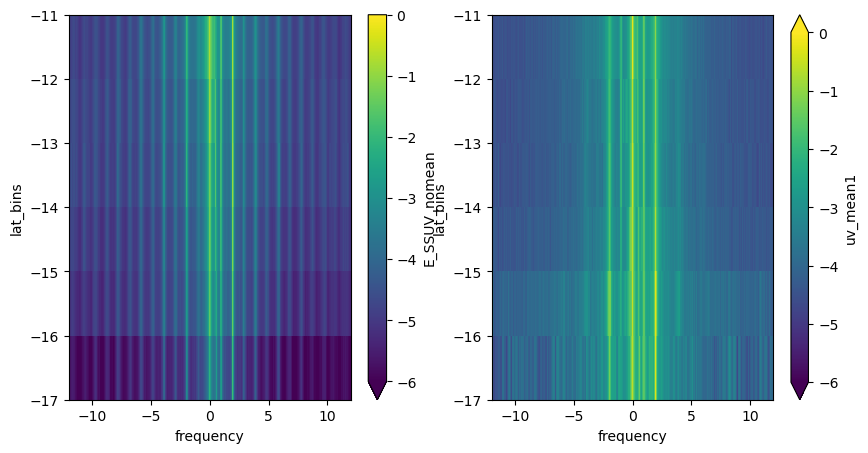

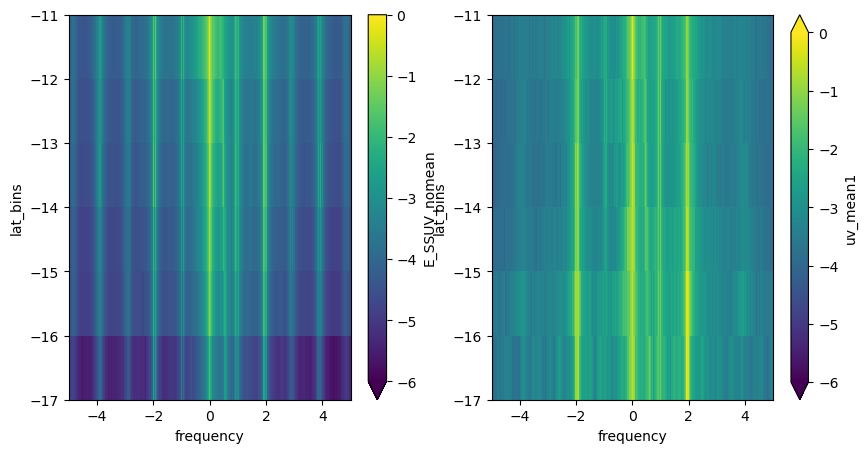

In [99]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
np.log10(dsE_NWA['E_SSUV_nomean']).plot(y='lat_bins',ax=ax[0],vmax=0,vmin=-6)
np.log10(ds_NWA['uv_mean1']).plot(y='lat_bins',ax=ax[1],vmax=0,vmin=-6)
for a in ax:
    a.set_ylim(-17,-11)
fig,ax = plt.subplots(1,2,figsize=(10,5))
np.log10(dsE_NWA['E_SSUV_nomean']).plot(y='lat_bins',ax=ax[0],vmax=0,vmin=-6)
np.log10(ds_NWA['uv_mean1']).plot(y='lat_bins',ax=ax[1],vmax=0,vmin=-6)
for a in ax:
    a.set_xlim(-5,5);a.set_ylim(-17,-11)

(-5.0, 5.0)

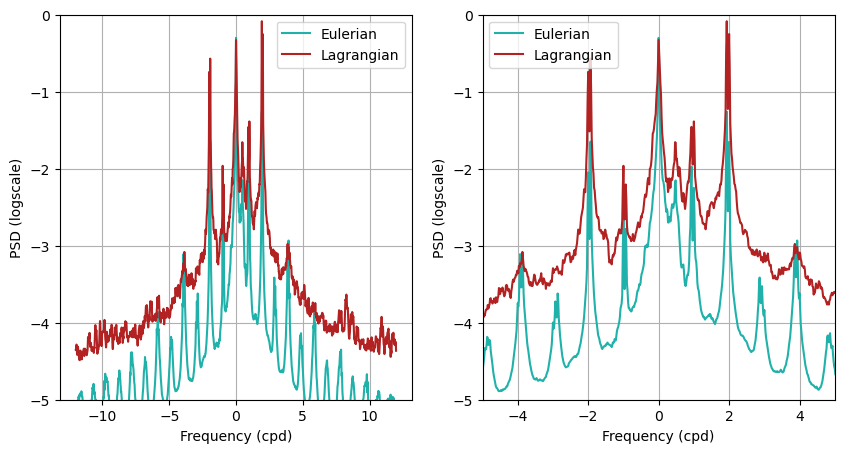

In [91]:
#colors=['k','r','g']
colors=['lightseagreen','firebrick']
styles=['-','--','-.']
labels=['Eulerian','Lagrangian']
fig, ax = plt.subplots(1,2,figsize=(10,5))
#for V,c,style in zip(dsE_Cal.keys(),colors,styles):
np.log10(dsE_NWA['E_SSUV'].mean(dim='lat_bins',skipna=True)).plot(ax=ax[0],c=colors[0],linestyle=styles[0])
np.log10(dsE_NWA['E_SSUV'].mean(dim='lat_bins',skipna=True)).plot(ax=ax[1],c=colors[0],linestyle=styles[0])
np.log10(ds_NWA['uv'].sel(lat_bins=slice(-17,-11)).mean(dim='lat_bins',skipna=True)).plot(ax=ax[0],c=colors[1],linestyle=styles[0])
np.log10(ds_NWA['uv'].sel(lat_bins=slice(-17,-11)).mean(dim='lat_bins',skipna=True)).plot(ax=ax[1],c=colors[1],linestyle=styles[0])
for a in ax:
    a.grid();a.set_ylim(-5,0);a.set_ylabel('PSD (logscale)')
    a.set_xlabel('Frequency (cpd)');
    a.legend(labels)
ax[1].set_xlim(-5,5)

(-5.0, 5.0)

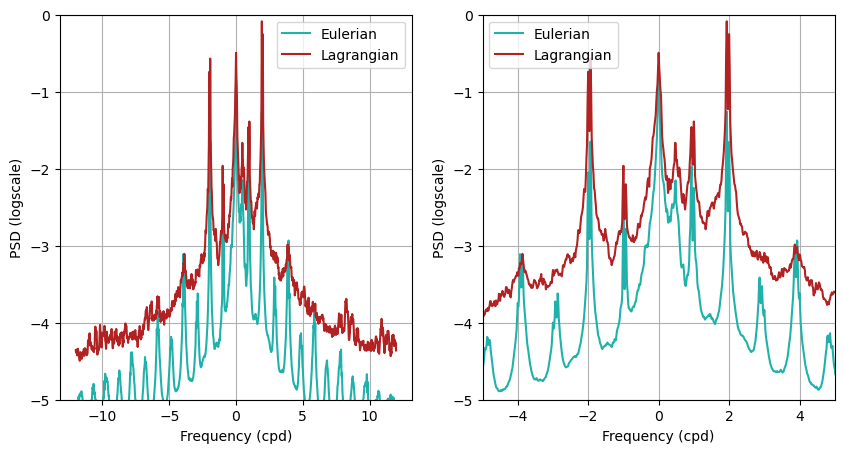

In [92]:
colors=['lightseagreen','firebrick']
styles=['-','--','-.']
labels=['Eulerian','Lagrangian']
fig, ax = plt.subplots(1,2,figsize=(10,5))
#for V,c,style in zip(dsE_Cal.keys(),colors,styles):
np.log10(dsE_NWA['E_SSUV_nomean'].mean(dim='lat_bins',skipna=True)).plot(ax=ax[0],c=colors[0],linestyle=styles[0])
np.log10(dsE_NWA['E_SSUV_nomean'].mean(dim='lat_bins',skipna=True)).plot(ax=ax[1],c=colors[0],linestyle=styles[0])
np.log10(ds_NWA['uv_mean1'].sel(lat_bins=slice(-17,-11)).mean(dim='lat_bins',skipna=True)).plot(ax=ax[0],c=colors[1],linestyle=styles[0])
np.log10(ds_NWA['uv_mean1'].sel(lat_bins=slice(-17,-11)).mean(dim='lat_bins',skipna=True)).plot(ax=ax[1],c=colors[1],linestyle=styles[0])
for a in ax:
    a.grid();a.set_ylim(-5,0);a.set_ylabel('PSD (logscale)')
    a.set_xlabel('Frequency (cpd)');
    a.legend(labels)
ax[1].set_xlim(-5,5)

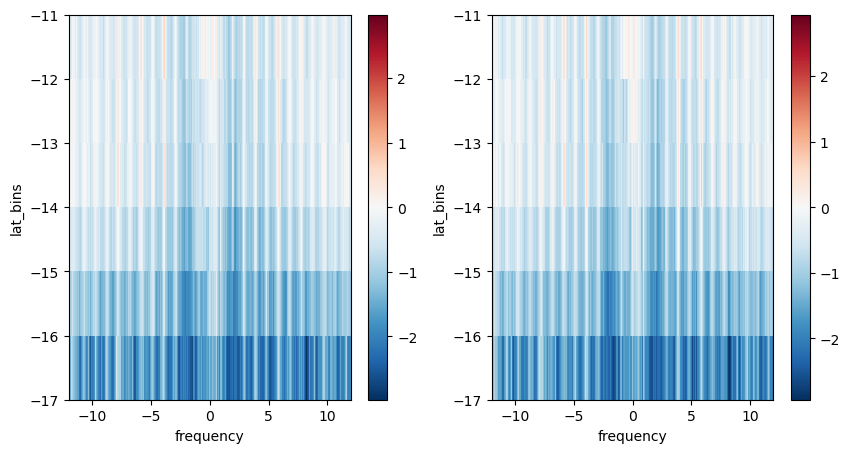

In [94]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
np.log10(dsE_NWA['E_SSUV']/ds_NWA['uv']).plot(y='lat_bins',cmap='RdBu_r',ax=ax[0])
np.log10(dsE_NWA['E_SSUV_nomean']/ds_NWA['uv_mean1']).plot(y='lat_bins',cmap='RdBu_r',ax=ax[1])
for a in ax:
    a.set_ylim(-17,-11)

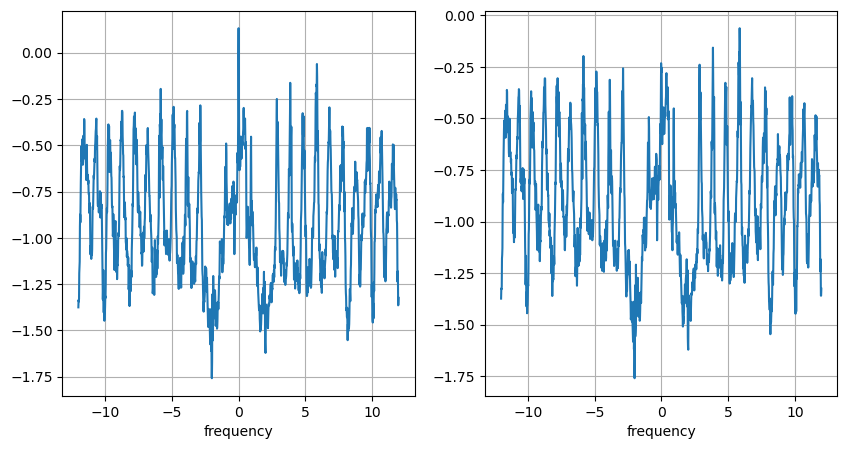

In [95]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
np.log10(dsE_NWA['E_SSUV'].mean('lat_bins')/ds_NWA['uv'].mean('lat_bins')).plot(ax=ax[0])
np.log10(dsE_NWA['E_SSUV_nomean'].mean('lat_bins')/ds_NWA['uv_mean1'].mean('lat_bins')).plot(ax=ax[1])
for a in ax :
    a.grid() 

In [8]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
